In [1]:
import pandas as pd
import pickle
import os
import json
import re
from PIL import Image
import pprint
from scipy.stats import norm
prettyprint = pprint.PrettyPrinter(indent=4)

In [2]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../../')

In [3]:
import os
import locale
locale.setlocale(locale.LC_TIME, "it_IT.UTF8")

from datetime import datetime, timedelta
from matplotlib import pyplot as plt, dates as mdates
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error
import pymc3 as pm

#from covid19_pytoolbox.settings import BASE_DATA_PATH, BASE_IMAGES_PATH
#BASE_DATA_PATH='../../data'
#BASE_IMAGES_PATH='../../images'
from covid19_pytoolbox import settings
settings.BASE_DATA_PATH='../../data'
settings.BASE_IMAGES_PATH='../../images'

from covid19_pytoolbox import plotting
from covid19_pytoolbox.italy.data import ISS
from covid19_pytoolbox.italy.data import DPC
from covid19_pytoolbox.smoothing.seasonalRSVD.LogRSVD import LogSeasonalRegularizer
from covid19_pytoolbox.smoothing.tikhonovreg import TikhonovRegularization
from covid19_pytoolbox.modeling.datarevision.seasonal import draw_expanded_series, smooth_and_drop
from covid19_pytoolbox.modeling.Rt.bayesian import MCMC_sample
from covid19_pytoolbox.modeling.Rt import naive
from covid19_pytoolbox.utils import smape, padnan, RSVD_smooth_data_generic

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
alpha = 1.87
beta = 0.28

ALPHA=100.

In [5]:
local_imported = ISS.read_weekly_cases_from_local(datetime.now()) #datetime(2021,7,7)
ISS.preprocess_cases(local_imported)
ISS.RSVD_smooth_data(local_imported, alpha, beta, difference_degree=6)

['total', 'imported']
total_deseason
info_cri:  1.9098737525964458
info_cri:  2.379086528483322
TIC R2: 0.993561248933464
patterns: 1
(   -16.409436012535135,
    2.592156149688225e-29,
    19,
    527,
    {   '1%': -3.442819521824351,
        '10%': -2.5696992792614384,
        '5%': -2.8670399588708047},
    -105.4372550146577)
new columns generated:
[   'total_deseason',
    'total_deseason_seasonality',
    'total_deseason_smoothed',
    'total_deseason_residuals',
    'total_deseason_relative_residuals',
    'total_deseason_smoothed_Rt']
imported_deseason
info_cri:  5.126066119086
info_cri:  9.940197597088263
TIC R2: 0.7390065528477152
patterns: 1
(   -18.557061431694542,
    2.0893764713958385e-30,
    19,
    527,
    {   '1%': -3.442819521824351,
        '10%': -2.5696992792614384,
        '5%': -2.8670399588708047},
    1288.6211394126826)
new columns generated:
[   'total_deseason',
    'total_deseason_seasonality',
    'total_deseason_smoothed',
    'total_deseason_residual

In [7]:
local_imported['dayofyear'] = local_imported.data.dt.dayofyear.astype(float)

In [8]:
local_imported['imported_ratio_CI_min'], local_imported['imported_ratio_CI_max'] = norm.interval(
    0.95, 
    loc=local_imported.imported_ratio_avg14, 
    scale=local_imported.imported_ratio_std14
)

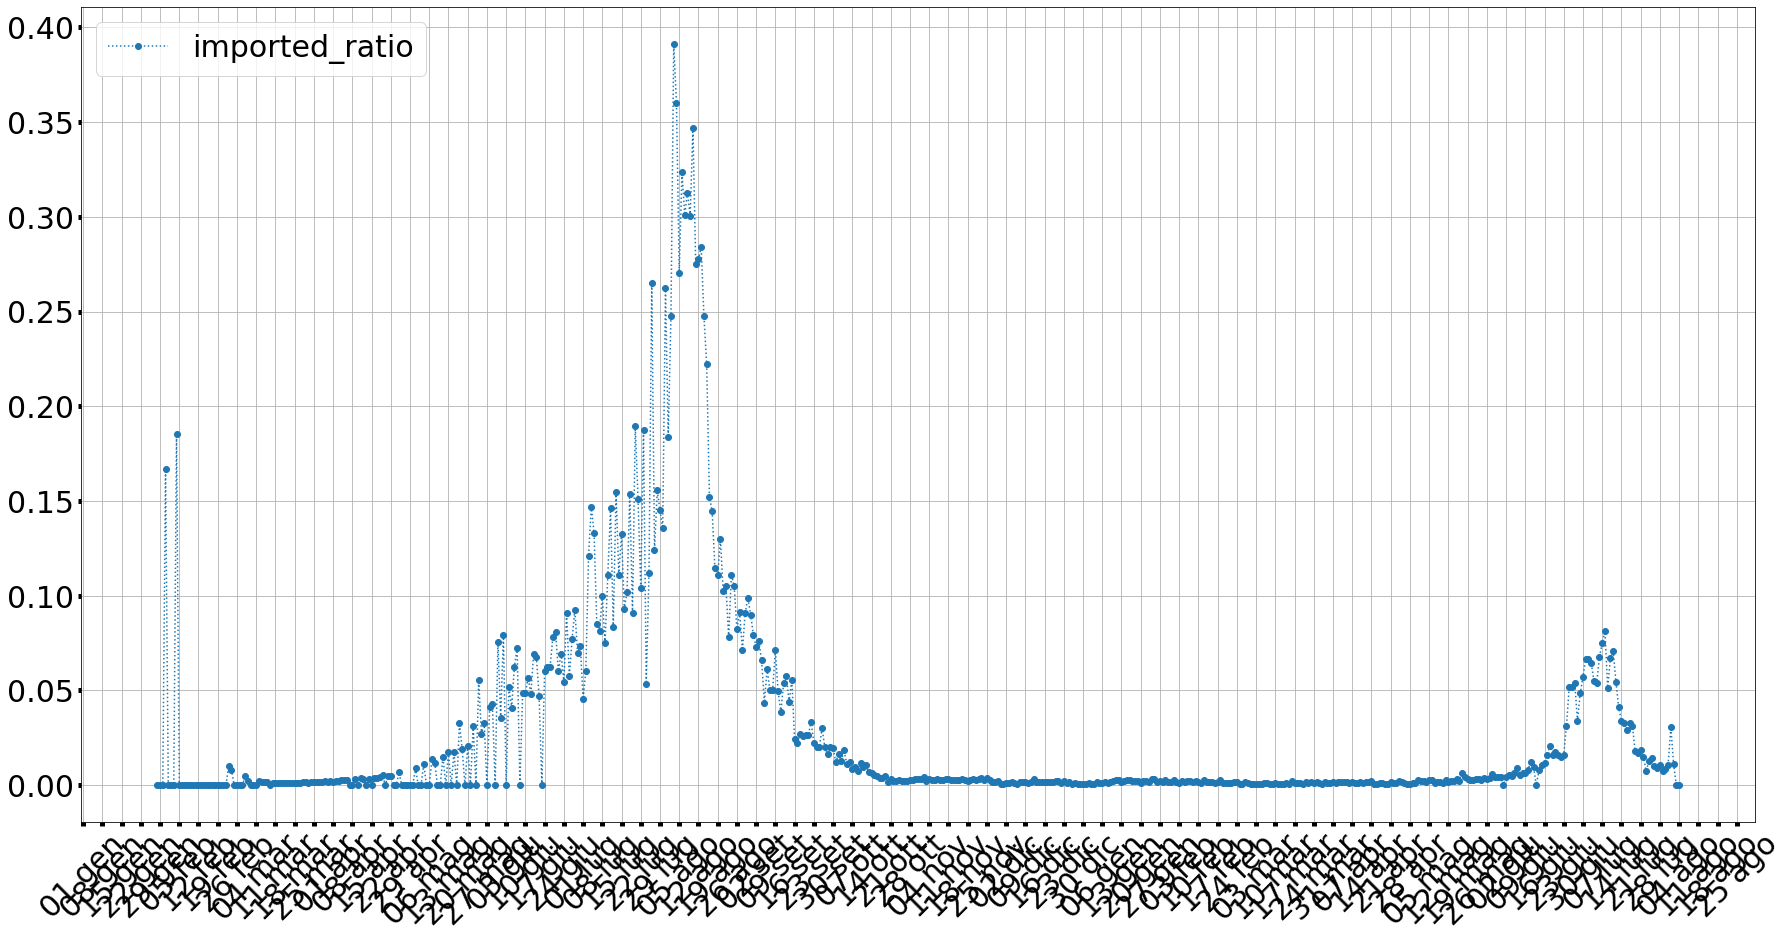

In [9]:
plotting.plot_series(
    df=local_imported,
    yfields=[
        'imported_ratio', 
    ],
    legend_loc="upper left"
)

In [10]:
local_imported["imported_ratio_deseason_smoothed"] = \
    local_imported.imported_deseason_smoothed/local_imported.total_deseason_smoothed

local_imported["imported_ratio_100_deseason_smoothed"] = \
    100*local_imported.imported_ratio_deseason_smoothed

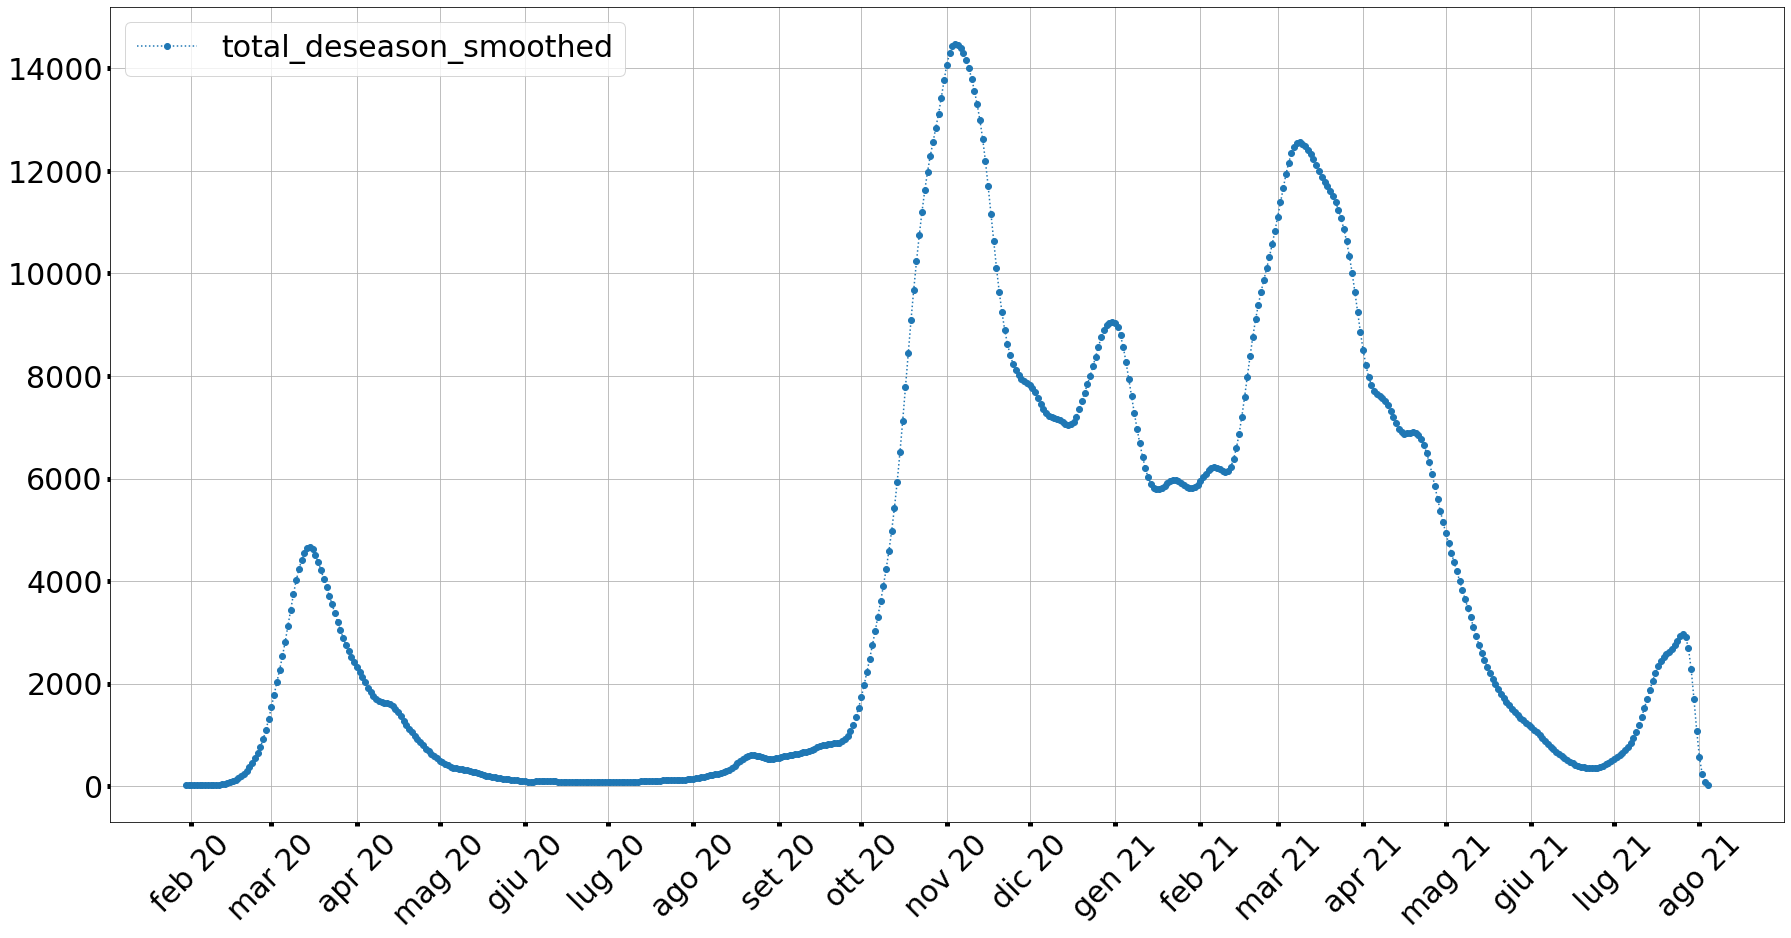

In [11]:
plotting.plot_series(
    df=local_imported,
    yfields=[
        'total_deseason_smoothed',
    ],
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),    
    legend_loc="upper left"
)

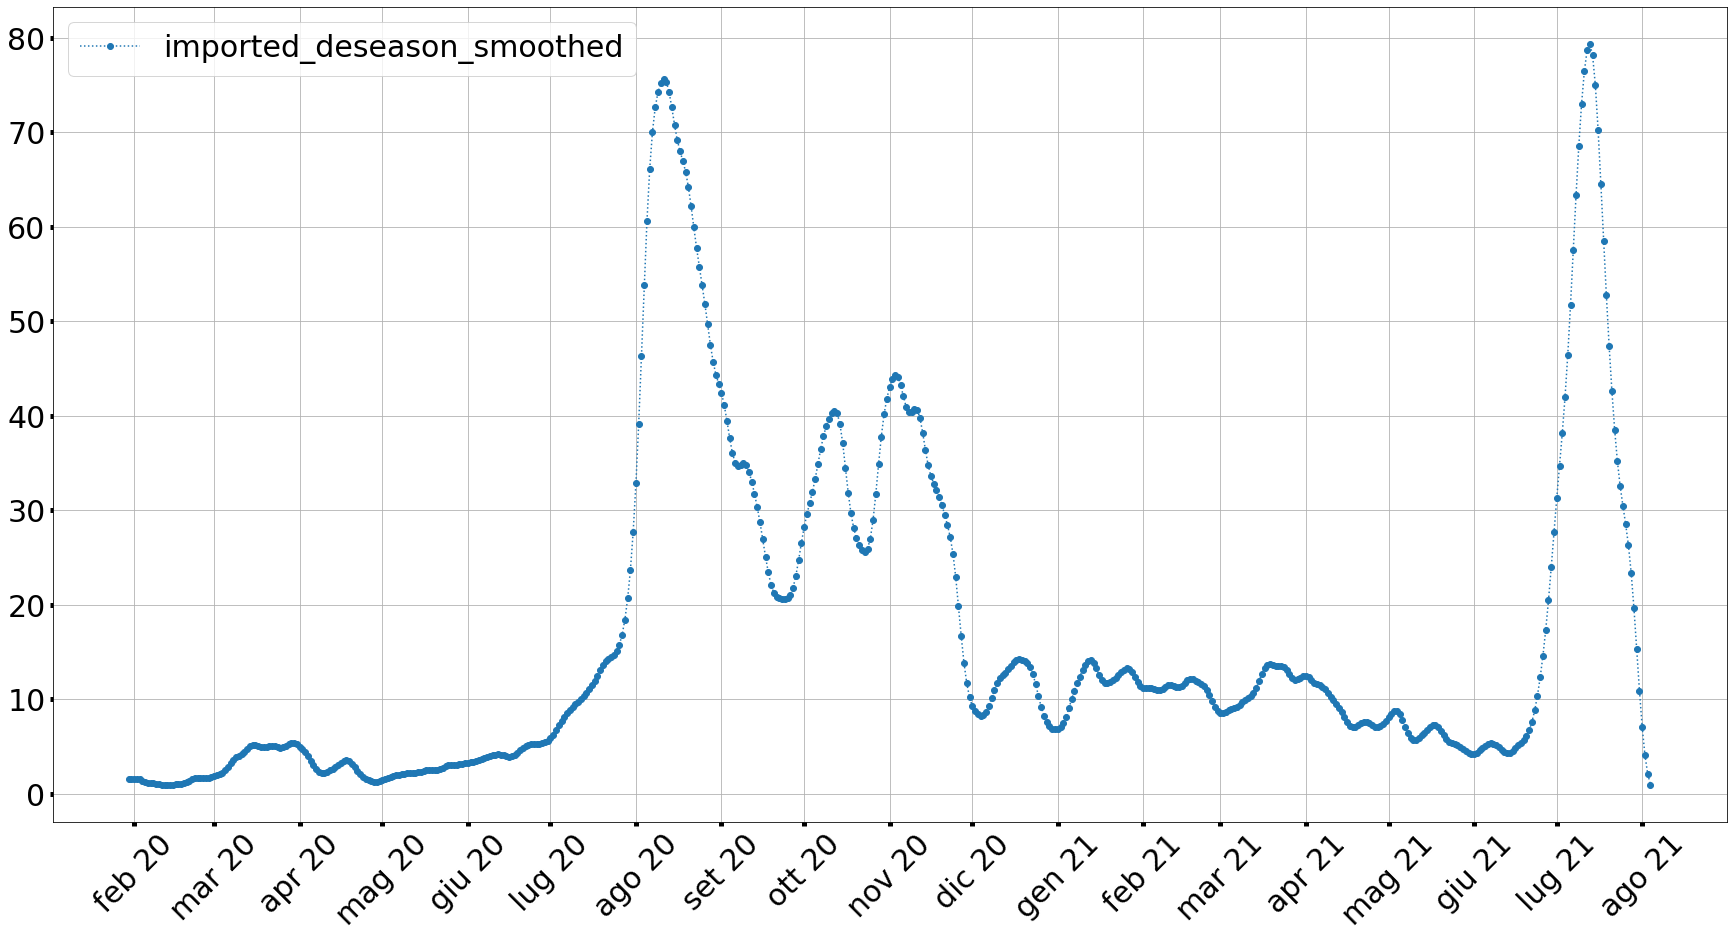

In [12]:
plotting.plot_series(
    df=local_imported,
    yfields=[
        'imported_deseason_smoothed',
    ],
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),    
    legend_loc="upper left"
)

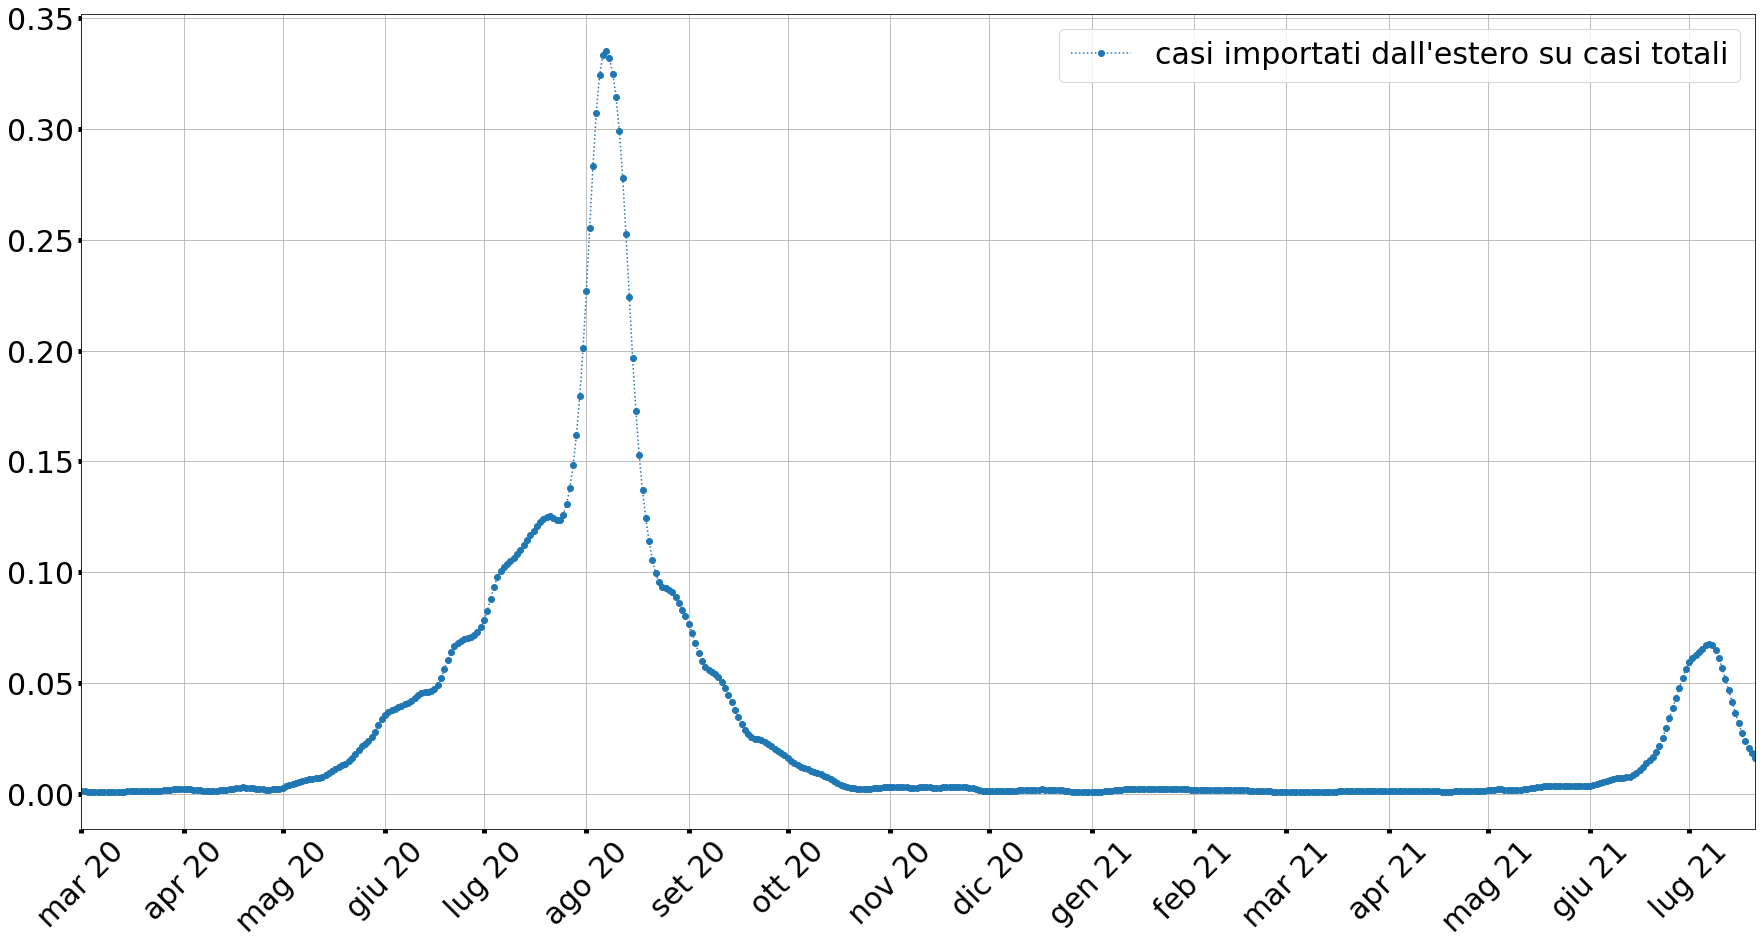

In [13]:
plotting.plot_series(
    data=[{
        'df': local_imported,
        'xfield': 'data',
        'yfields': [
            'imported_ratio_deseason_smoothed', 
        ],
        'labels':[
            'casi importati dall\'estero su casi totali',
        ]
    }],
    xlim=(datetime(2020,3,1), datetime(2021,7,21)),
    legend_loc="upper right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_global'),
    quality=40
)

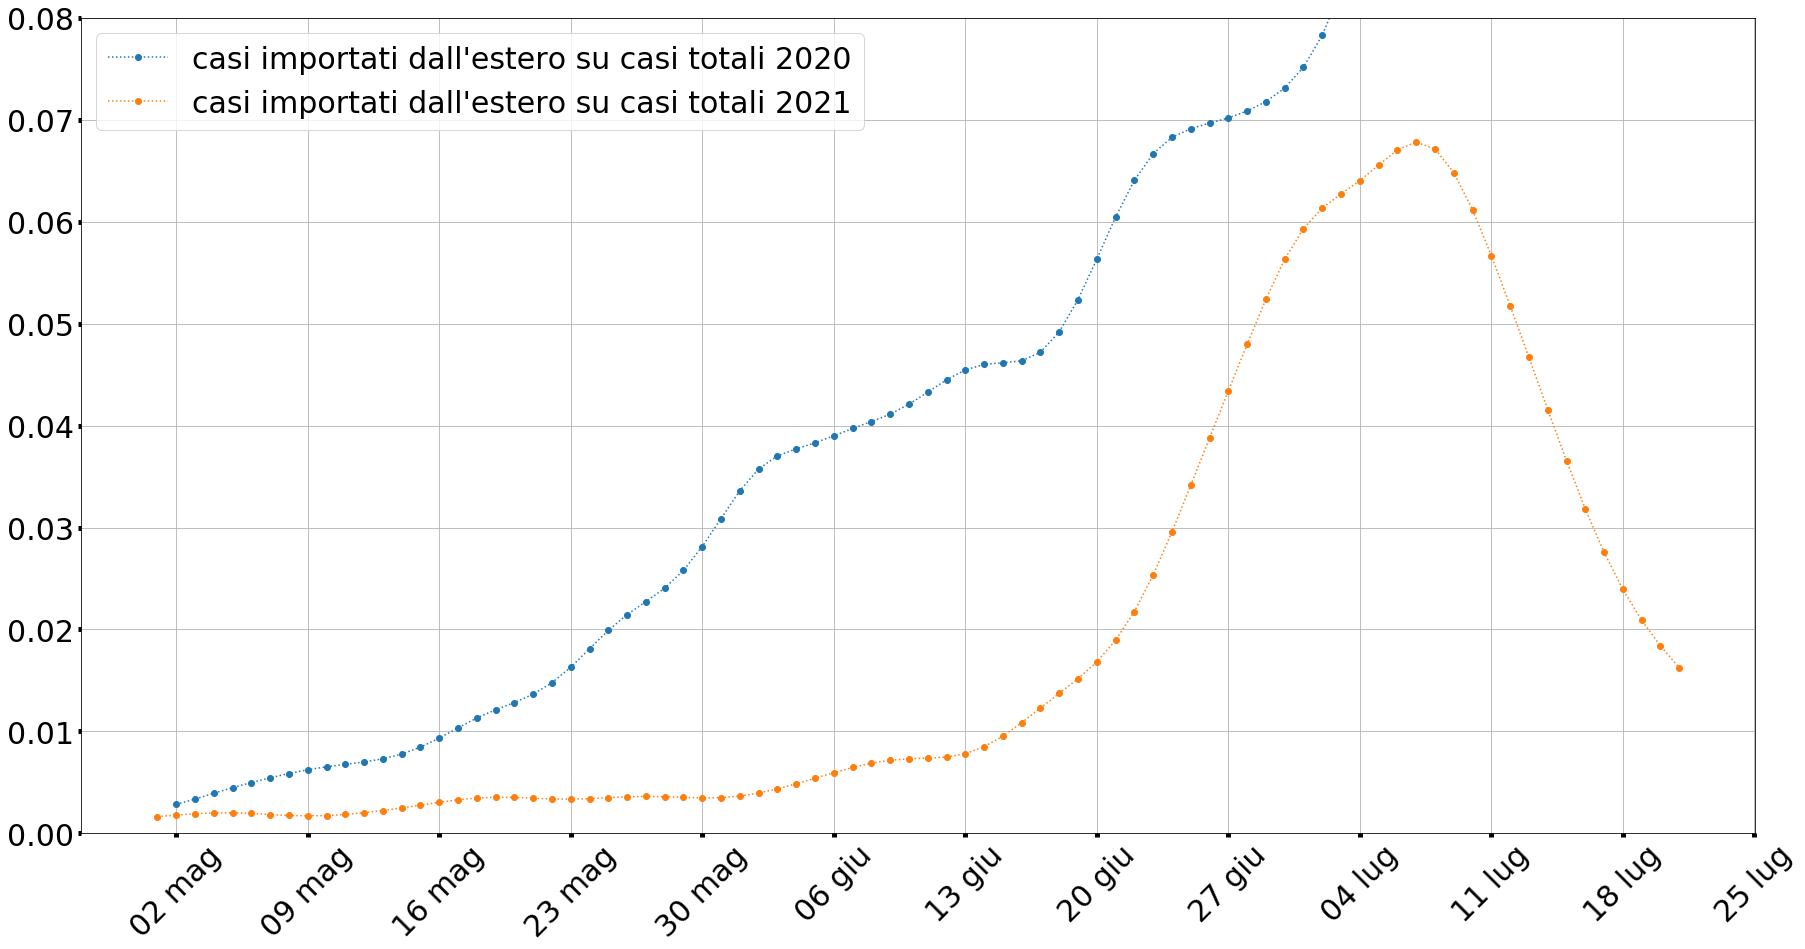

In [14]:
plotting.plot_series(
    data=[
        {
            'df': local_imported[(local_imported.data>="2020-05-01") & (local_imported.data<="2020-07-07")],
            'xfield': 'dayofyear',
            'yfields': [
                'imported_ratio_deseason_smoothed', 
            ],
            'labels':[
                'casi importati dall\'estero su casi totali 2020',
            ]
        },
        {
            'df': local_imported[(local_imported.data>="2021-05-01") & (local_imported.data<="2021-07-21")],
            'xfield': 'dayofyear',
            'yfields': [
                'imported_ratio_deseason_smoothed',                 
            ],
            'labels':[
                'casi importati dall\'estero su casi totali 2021',
            ]
        },        
    ],
    ylim=(0,0.08),
    #xlim=(datetime(2021,5,1), datetime(2021,6,29)),
    legend_loc="upper left",
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_zoom_2020_2021'),
    quality=40
)

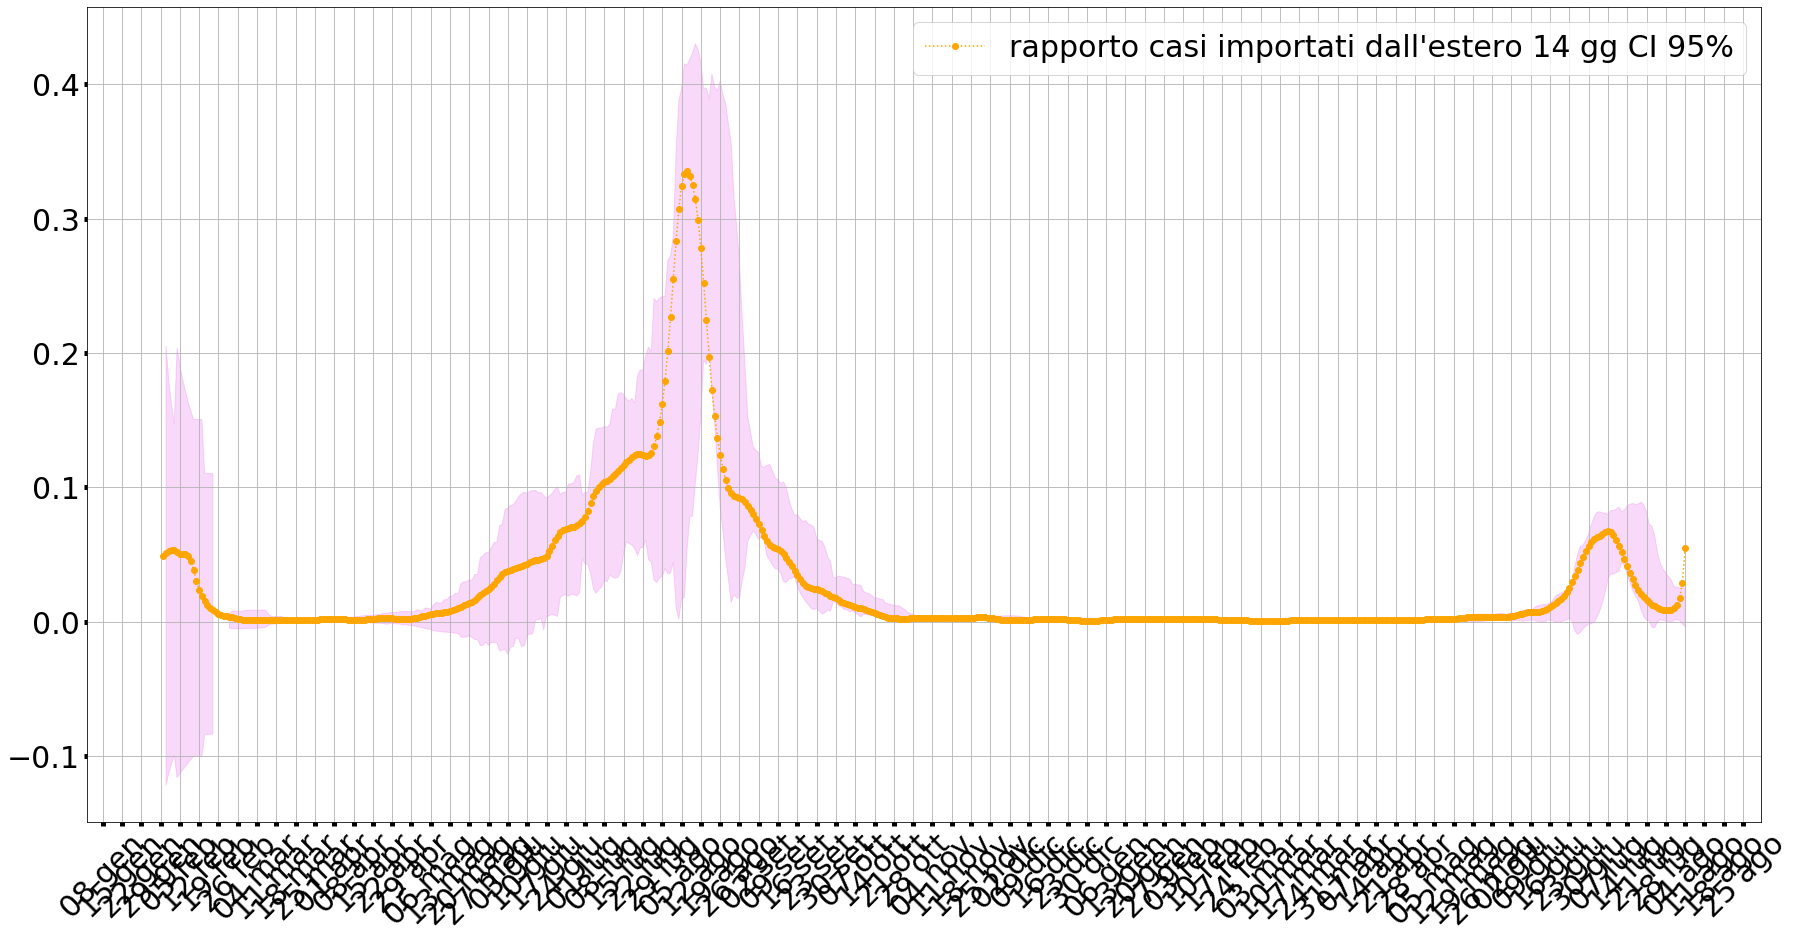

In [15]:
plotting.plot_series(
    data=[
        {
            'df': local_imported,
            'xfield': 'data',
            'yfields': [
                'imported_ratio_deseason_smoothed', 
            ],
            'fill_between': [
                'imported_ratio_CI_min',
                'imported_ratio_CI_max',
            ],
            'labels': [
                'rapporto casi importati dall\'estero 14 gg CI 95%',
            ],
            'colors':['orange']
        },        
    ],
    legend_loc="upper right"
)

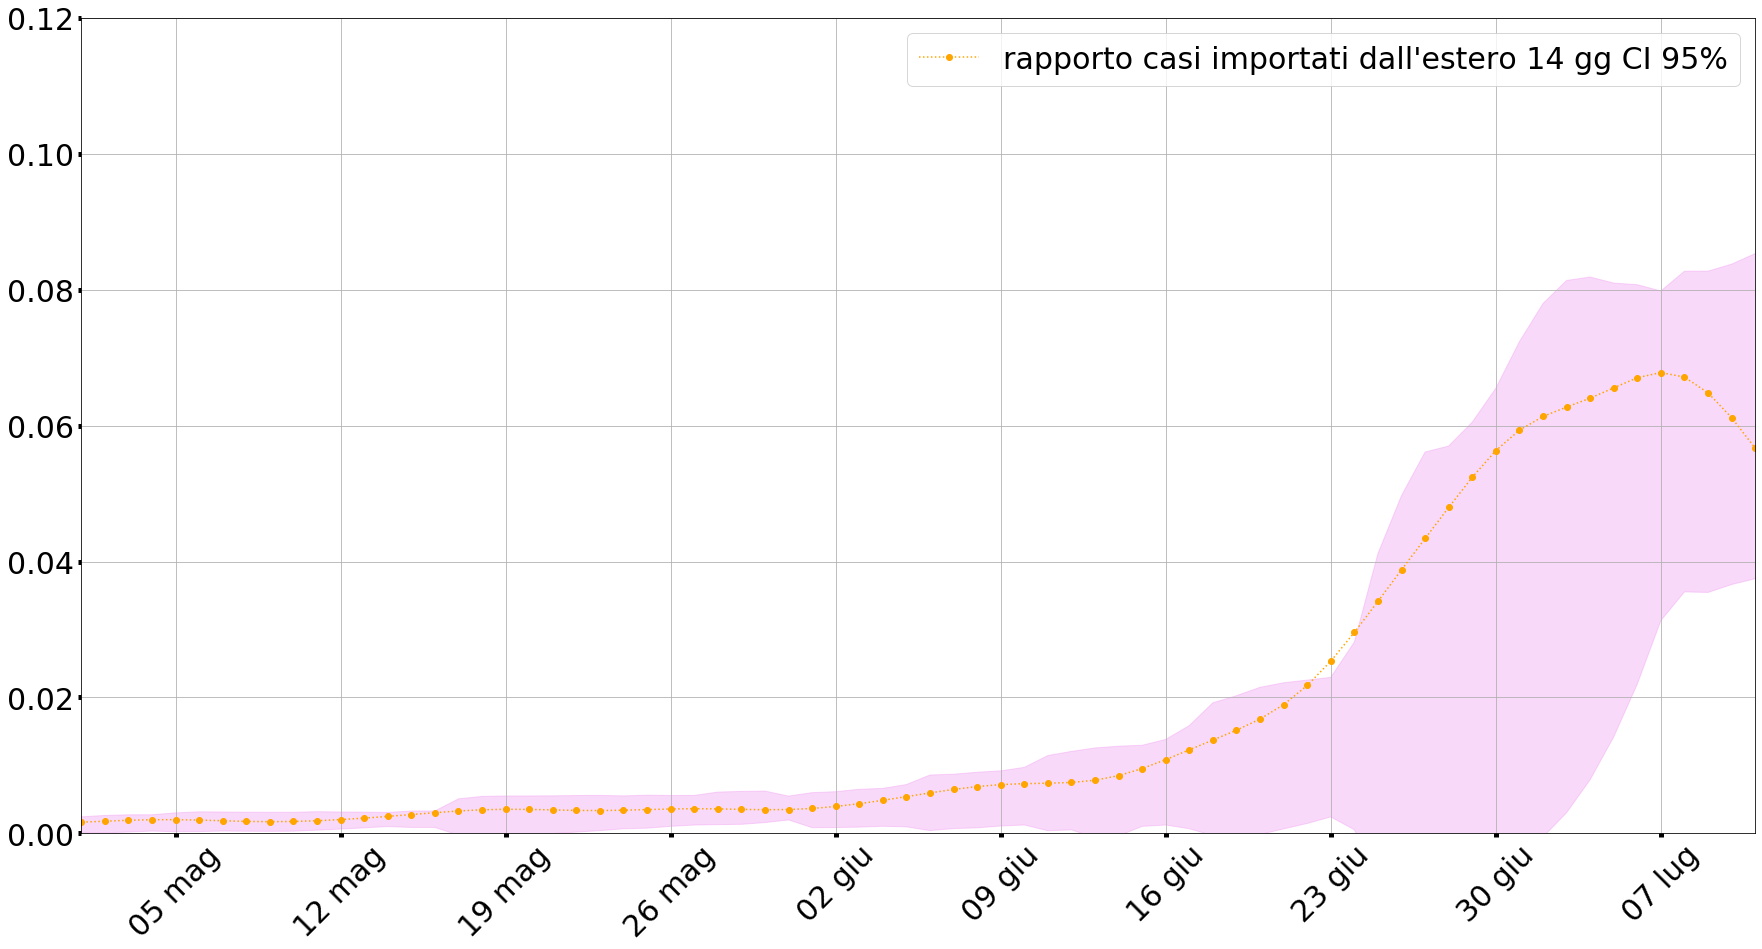

In [16]:
plotting.plot_series(
    data=[
        {
            'df': local_imported,
            'xfield': 'data',
            'yfields': [
                'imported_ratio_deseason_smoothed', 
            ],
            'fill_between': [
                'imported_ratio_CI_min',
                'imported_ratio_CI_max',
            ],
            'labels': [
                'rapporto casi importati dall\'estero 14 gg CI 95%',
            ],
            'colors':['orange']
        },        
    ],
    #xlim=(datetime(2020,7,25), datetime(2020,10,1)),#DPC_data.data.max()),
    #ylim=(-1000,1000),
    xlim=(datetime(2021,5,1), datetime(2021,7,11)),
    ylim=(0,0.12),
    legend_loc="upper right"
)

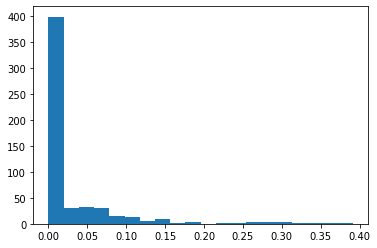

In [17]:
_ = plt.hist(local_imported.imported_ratio, bins=20)

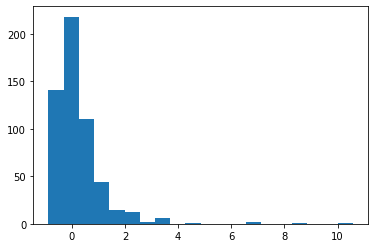

In [18]:
_=plt.hist(local_imported.imported_deseason_relative_residuals, bins=20)

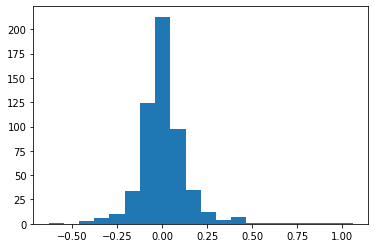

In [19]:
_=plt.hist(local_imported.total_deseason_relative_residuals, bins=20)

In [20]:
local_imported['imported_ratio_residuals'] = local_imported.imported_ratio - local_imported.imported_ratio_deseason_smoothed
local_imported['imported_ratio_rel_residuals'] = local_imported.imported_ratio_residuals /local_imported.imported_ratio

In [21]:
(local_imported.imported_ratio_rel_residuals==-np.inf).any()

True

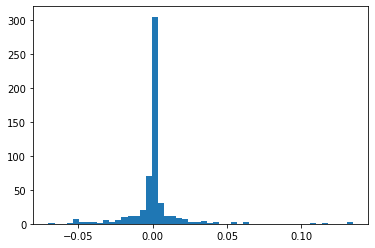

In [22]:
_ = plt.hist(local_imported.imported_ratio_residuals,bins=50)

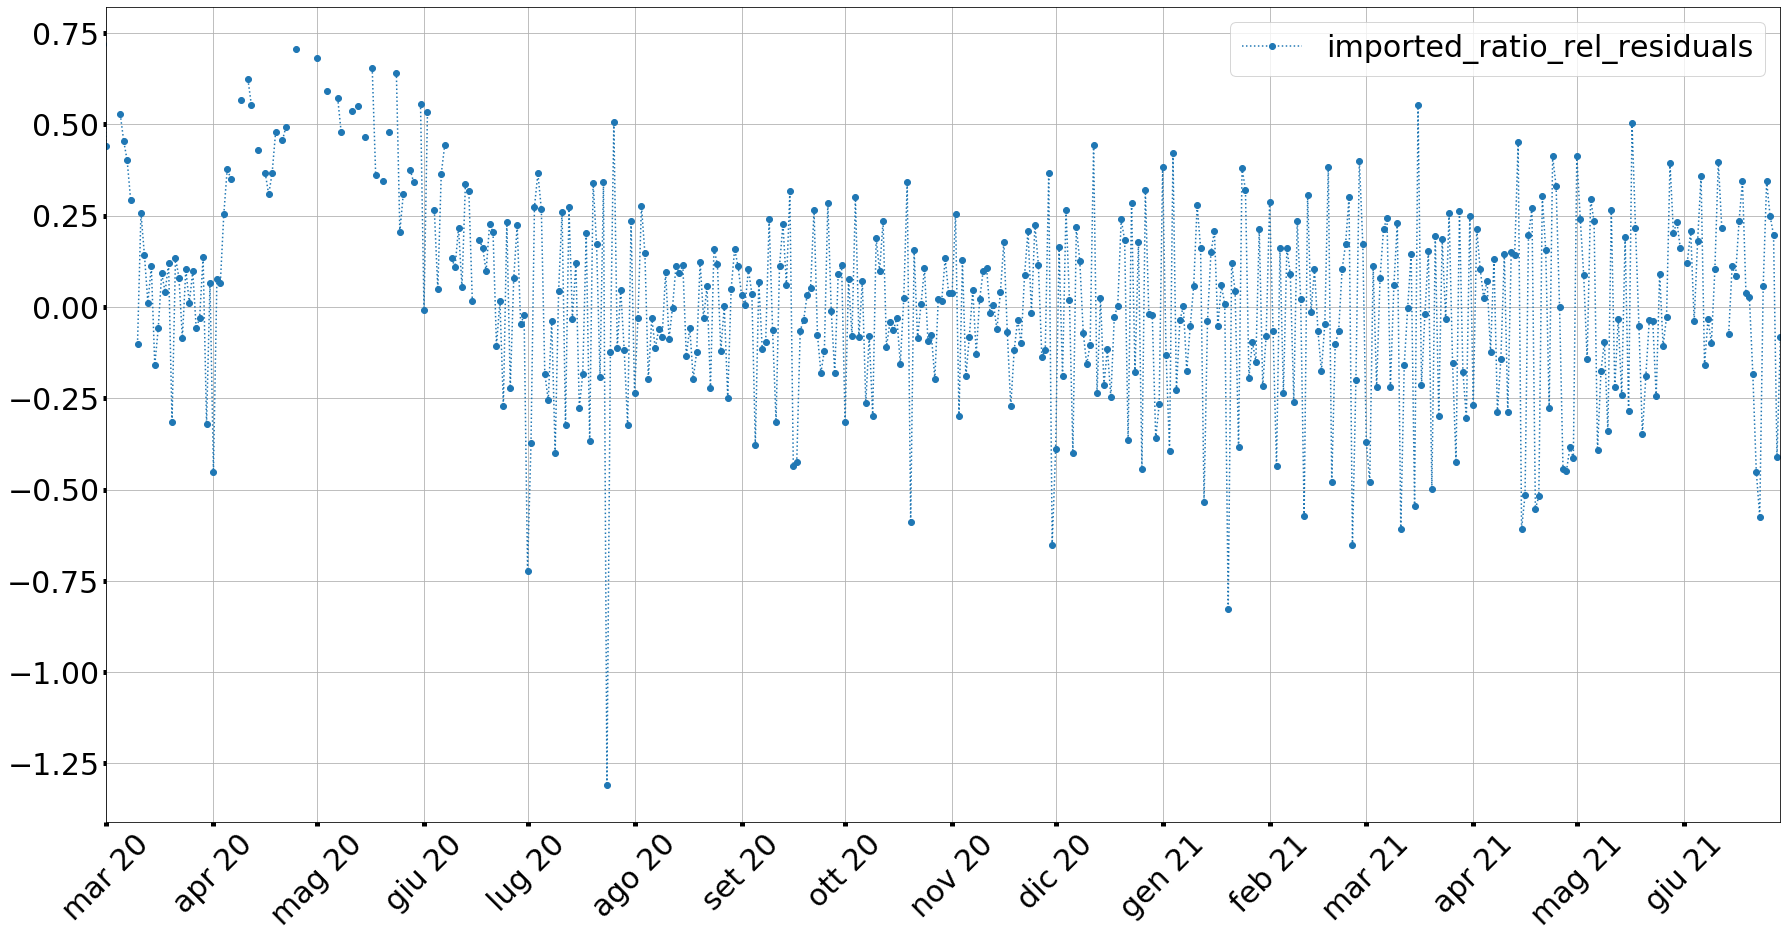

In [23]:
plotting.plot_series(
    data=[{
        'df': local_imported,
        'xfield': 'data',
        'yfields': [
            'imported_ratio_rel_residuals', 
        ],
    }],
    xlim=(datetime(2020,3,1), datetime(2021,6,29)),
    legend_loc="upper right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_global'),
    quality=40
)

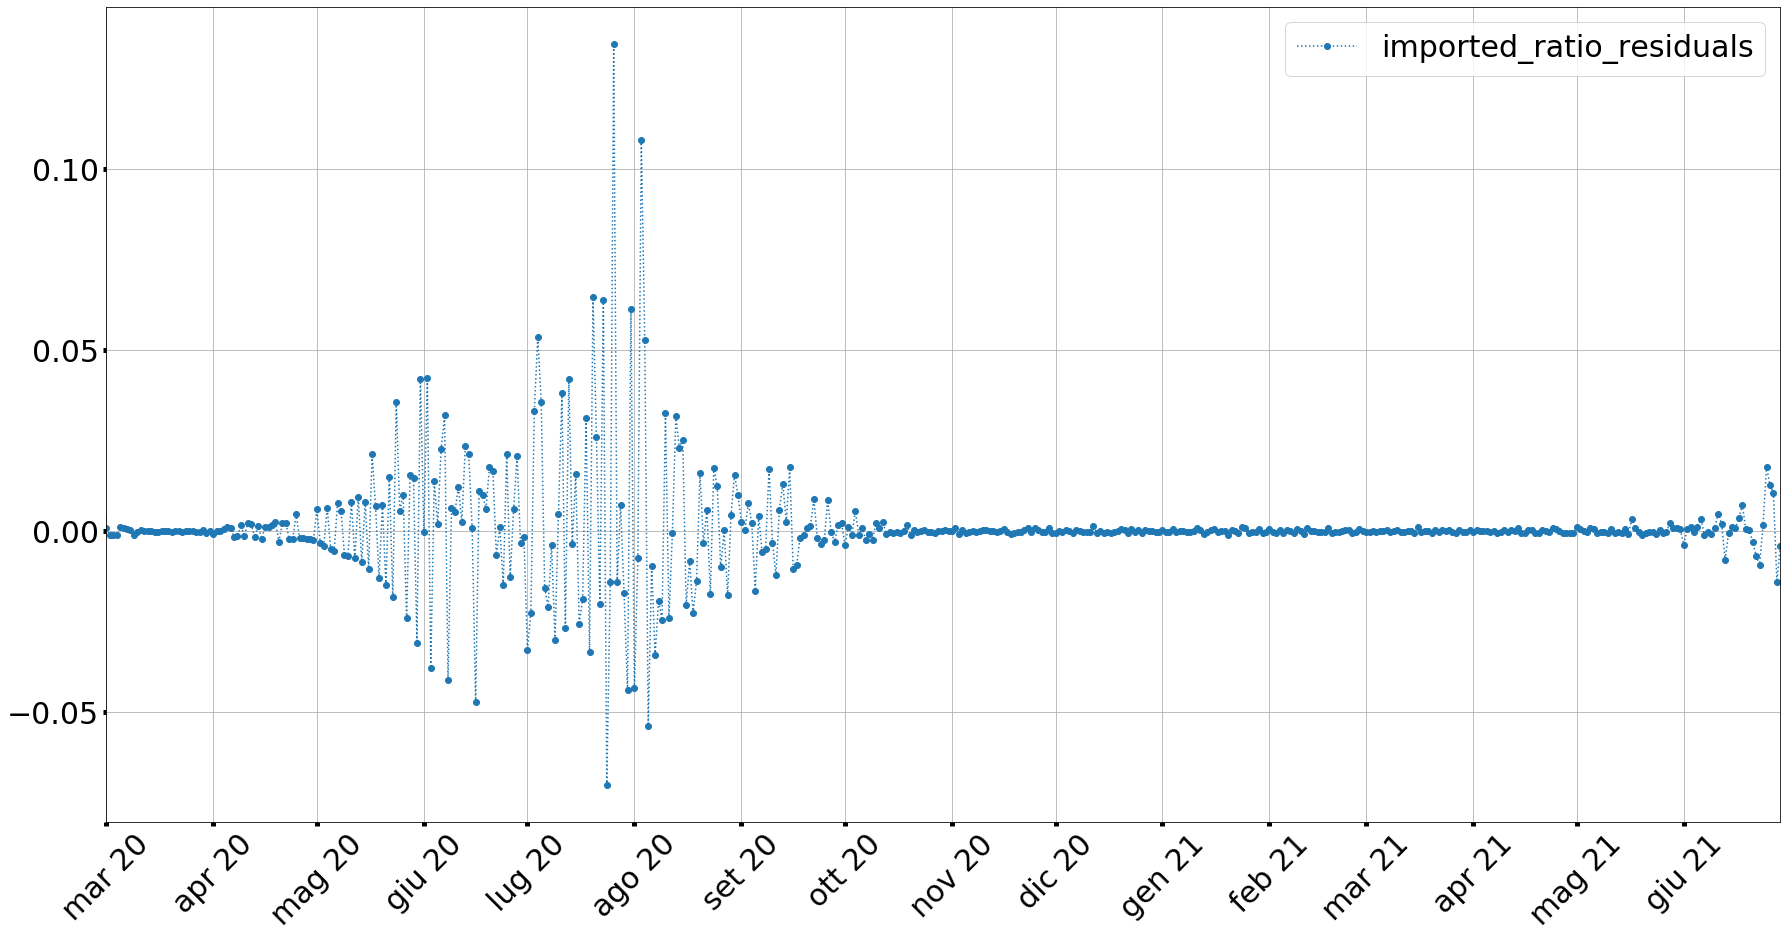

In [24]:
plotting.plot_series(
    data=[{
        'df': local_imported,
        'xfield': 'data',
        'yfields': [
            'imported_ratio_residuals', 
        ],
    }],
    xlim=(datetime(2020,3,1), datetime(2021,6,29)),
    legend_loc="upper right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_global'),
    quality=40
)

In [25]:
DPC_data = DPC.load_daily_cases_from_github()
TIMESTEPS, FIRST_CASI_SOSP_DIAGNOSTICO = DPC.preprocess(DPC_data)
DPC.compute_first_diffs(DPC_data)
regularizer = TikhonovRegularization(timesteps=TIMESTEPS, alpha=ALPHA)
DPC.tikhonov_smooth_differentiate(DPC_data, regularizer)

DPC_data = DPC.merge_ISS_weekly_cases(DPC_data, local_imported)
DPC.RSVD_smooth_data(DPC_data, alpha=alpha, beta=beta, difference_degree=2, trend_alpha=ALPHA)
DPC.compute_cases_corrected_by_imported(DPC_data)

{   'deceduti_giornalieri': 'deceduti',
    'dimessi_guariti_giornalieri': 'dimessi_guariti',
    'nuovi_casi_da_screening': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico': 'casi_da_sospetto_diagnostico',
    'nuovi_ospedalizzati': 'hospitalized_cumulative',
    'tamponi_giornalieri': 'tamponi'}
{   'deceduti_giornalieri_smoothed': 'deceduti',
    'dimessi_guariti_giornalieri_smoothed': 'dimessi_guariti',
    'nuovi_casi_da_screening_smoothed': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico_smoothed': 'casi_da_sospetto_diagnostico',
    'nuovi_ospedalizzati_smoothed': 'hospitalized_cumulative',
    'nuovi_positivi_smoothed': 'totale_casi',
    'tamponi_giornalieri_smoothed': 'tamponi'}
tamponi_giornalieri_smoothed - TIC R2: 0.9999974921414745
dimessi_guariti_giornalieri_smoothed - TIC R2: 0.9999966929604179
deceduti_giornalieri_smoothed - TIC R2: 0.9999982267910886
nuovi_positivi_smoothed - TIC R2: 0.9999984102380824
nuovi_casi_da_sospetto_diagnostico_smoot

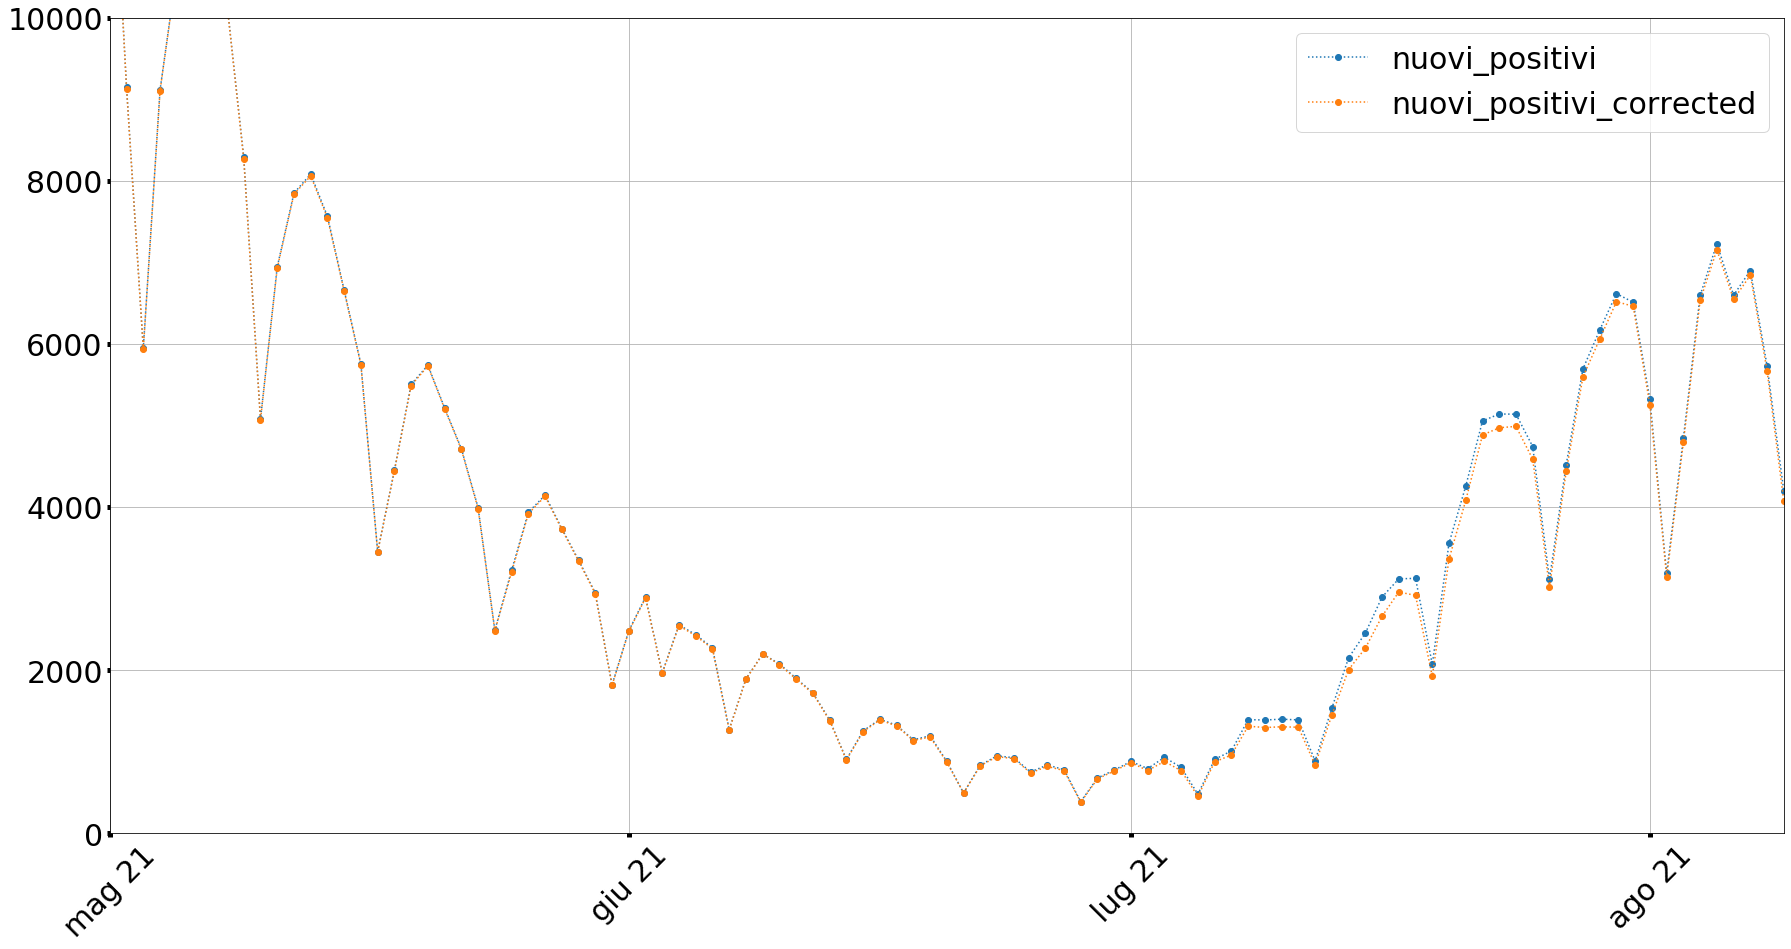

In [27]:
plotting.plot_series(
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields': [
            #'nuovi_positivi_deseason_smoothed_corrected', 
            #'nuovi_positivi_deseason_smoothed',
            'nuovi_positivi',
            'nuovi_positivi_corrected'
        ],
    }],
    xlim=(datetime(2021,5,1), DPC_data.data.max()),
    ylim=(0,10000),
    legend_loc="upper right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_global'),
    quality=40
)

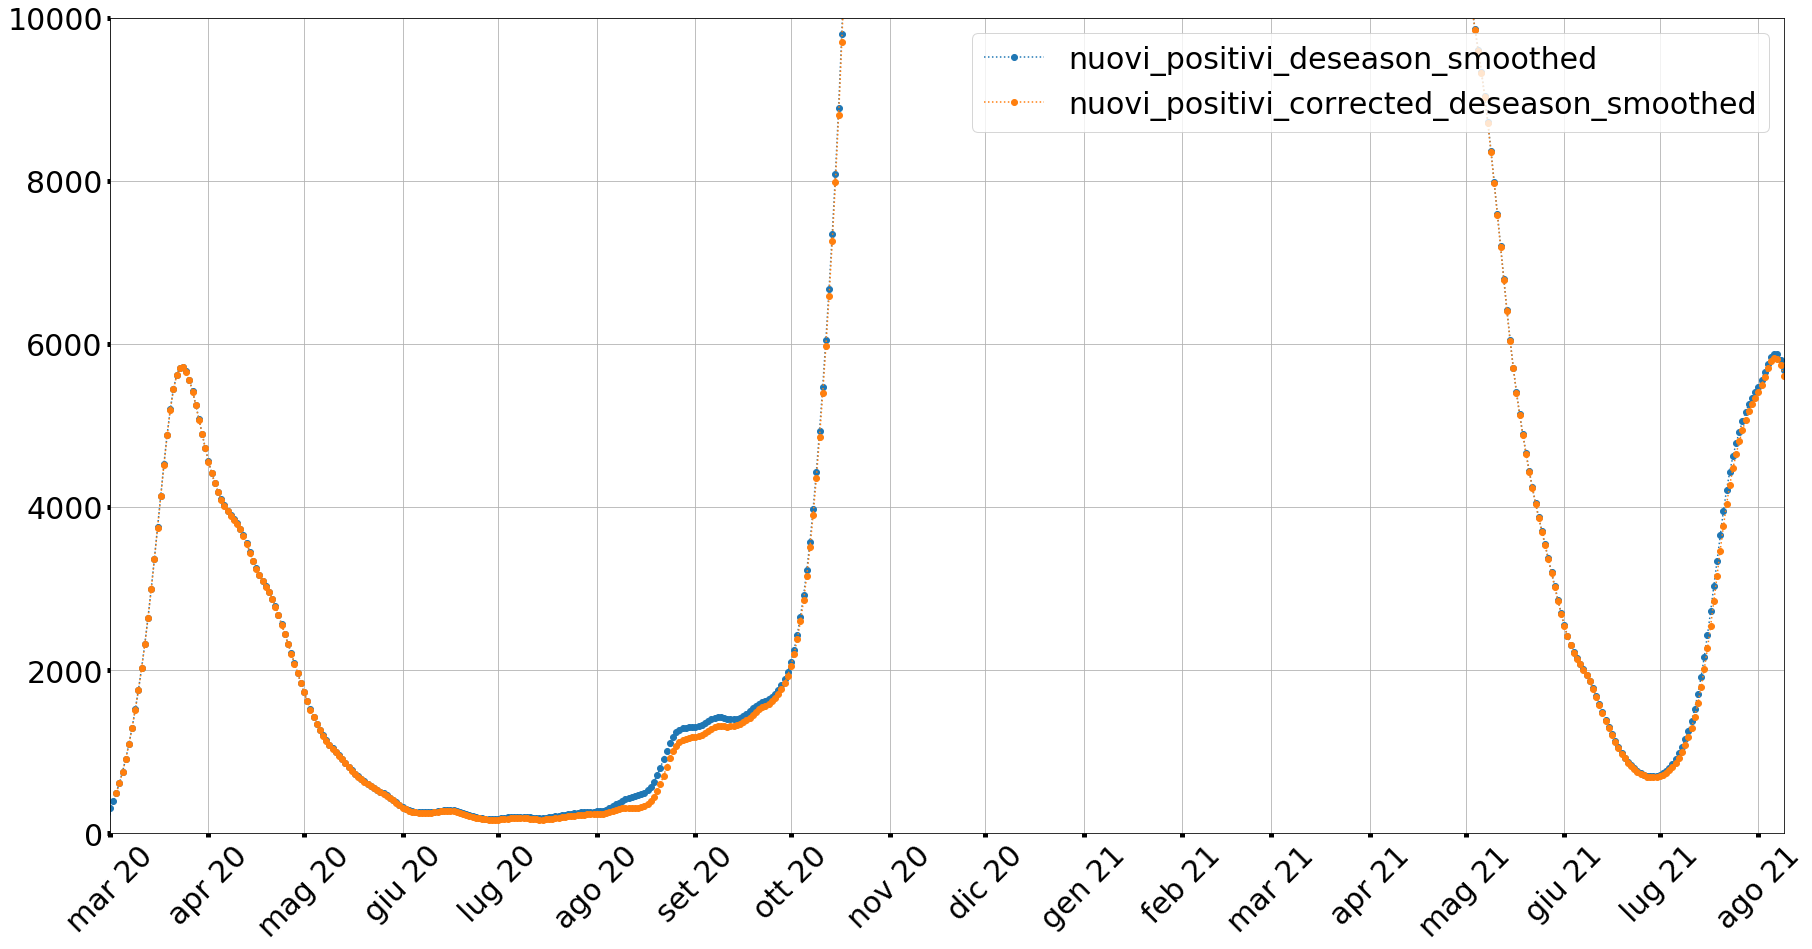

In [28]:
plotting.plot_series(
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields': [
            'nuovi_positivi_deseason_smoothed',
            'nuovi_positivi_corrected_deseason_smoothed',
        ],
    }],
    xlim=(datetime(2020,3,1), DPC_data.data.max()),
    ylim=(0,10000),
    legend_loc="upper right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_global'),
    quality=40
)

In [29]:
DPC_data['nuovi_positivi_corrected_deseason_smoothed_Rt'] = naive.compute_Rt(
    DPC_data.nuovi_positivi_corrected_deseason_smoothed.fillna(0), alpha=alpha, beta=beta,
    imported_series = DPC_data.imported_ratio_deseason_smoothed_shifted.fillna(0)*DPC_data.nuovi_positivi_deseason_smoothed.fillna(0)
).fillna(0)

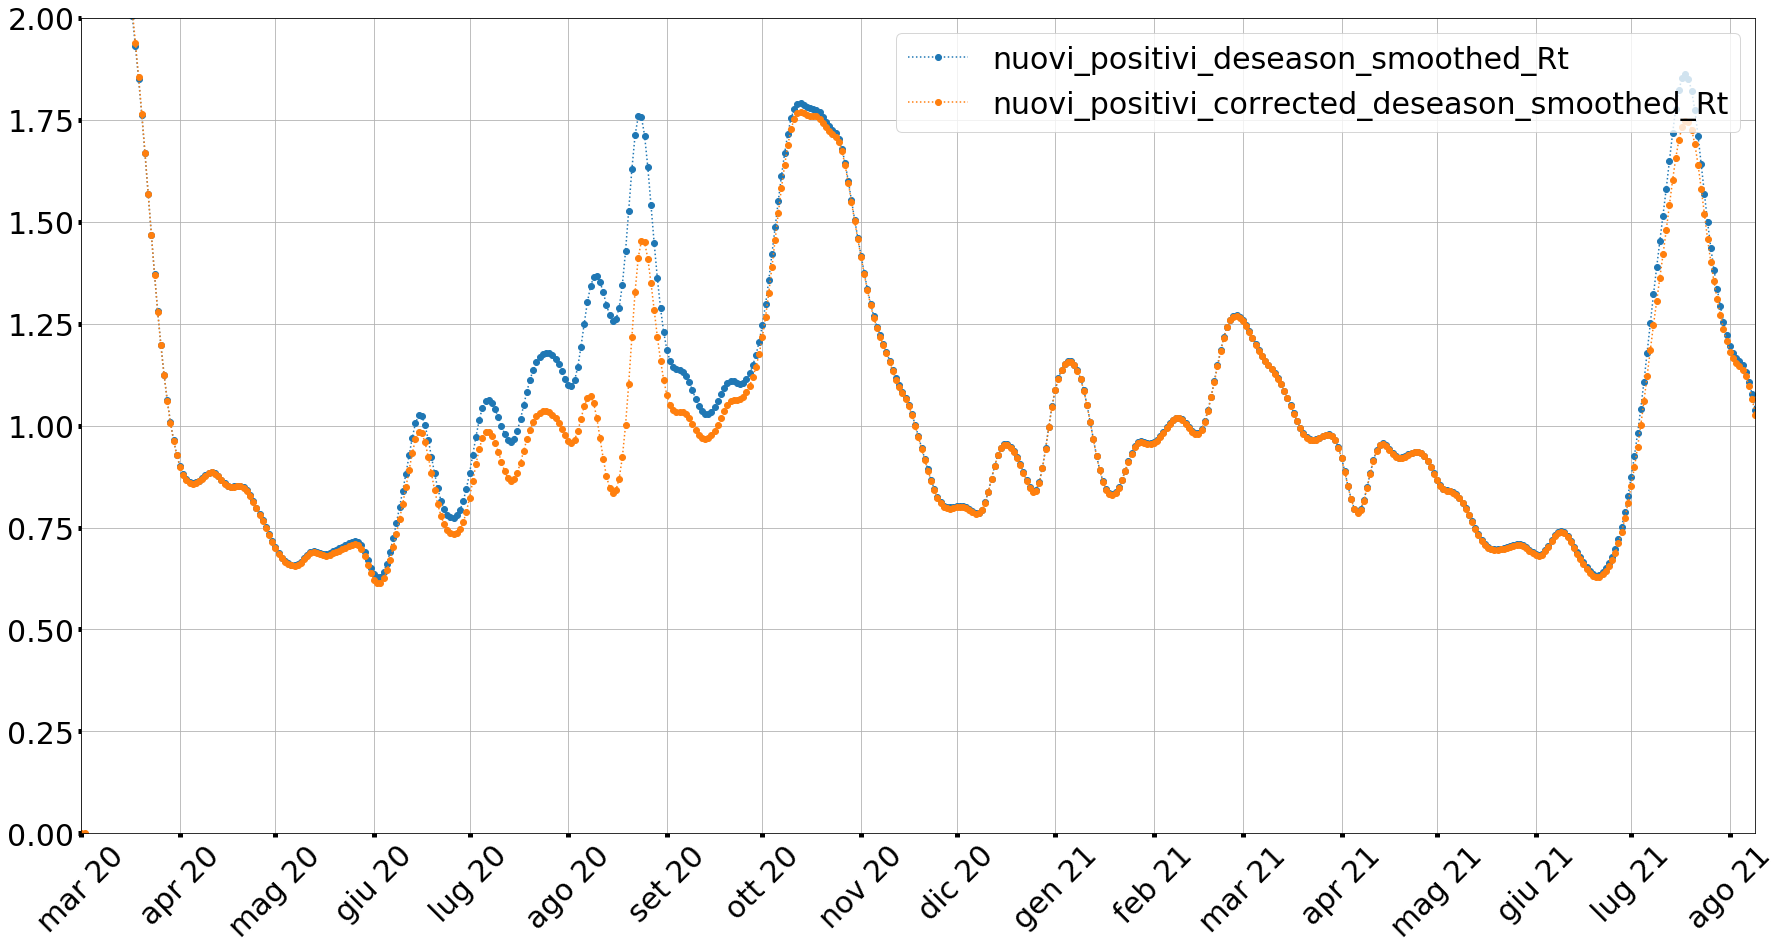

In [30]:
plotting.plot_series(
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields': [
            'nuovi_positivi_deseason_smoothed_Rt',
            'nuovi_positivi_corrected_deseason_smoothed_Rt',
        ],
    }],
    xlim=(datetime(2020,3,1), DPC_data.data.max()),
    ylim=(0.,2.),
    legend_loc="upper right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_global'),
    quality=40
)

In [31]:
ISS_Rt = ISS.read_weekly_Rt_from_local()
ISS_Rt_clean = ISS.preprocess(ISS_Rt)
ISS_Rt_clean.tail()

,computation_time_range_start,computation_time_range_end,Rt,Rt_95_min,Rt_95_max,Rt_95_err_max,Rt_95_err_min,Rt_reference_date
46,2021-06-09,2021-06-22,0.63,0.61,0.71,0.08,0.02,2021-06-15 23:59:00
47,2021-06-16,2021-06-29,0.66,0.62,0.85,0.19,0.04,2021-06-22 23:59:00
48,2021-06-23,2021-07-06,0.91,0.67,1.32,0.41,0.24,2021-06-29 23:59:00
49,2021-06-30,2021-07-13,1.26,0.96,1.62,0.36,0.30,2021-07-06 23:59:00
50,2021-07-06,2021-07-20,1.57,1.34,1.82,0.25,0.23,2021-07-13 23:59:00


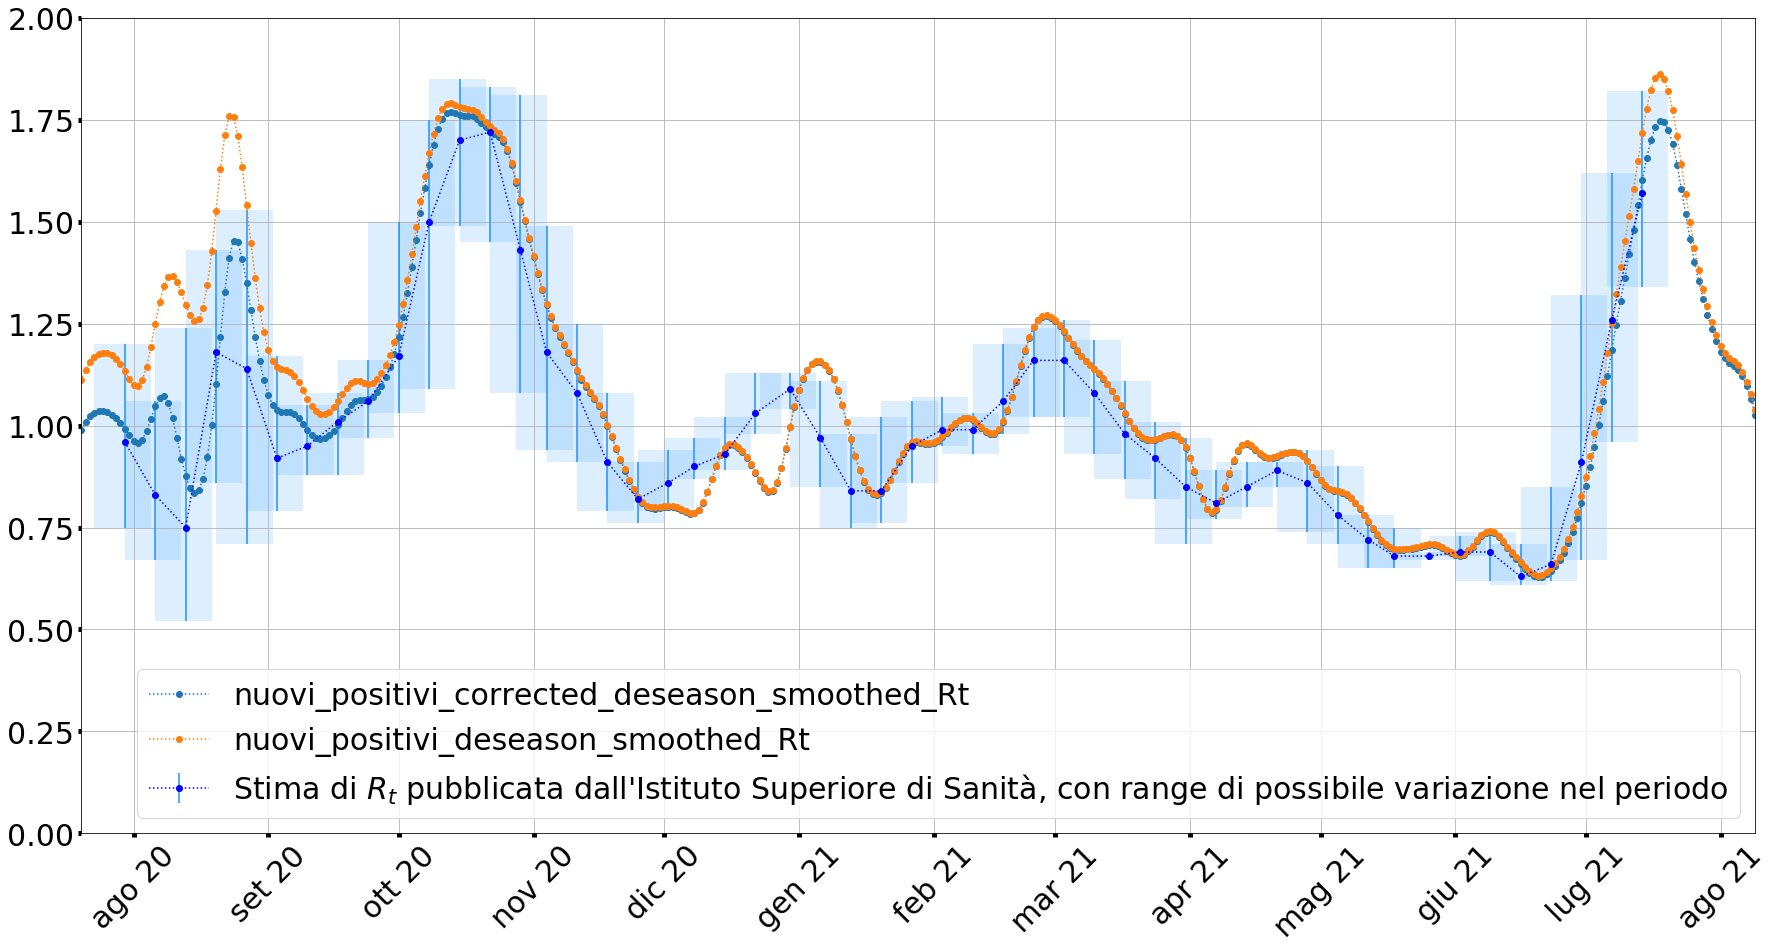

In [32]:
plotting.plot_series(
    data=[
        {
            'df': ISS_Rt_clean,
            'xfield': 'Rt_reference_date',
            'yfields': ['Rt'],
            'bars': [['Rt_95_err_min','Rt_95_err_max']],
            'timeranges': [['computation_time_range_start', 'computation_time_range_end']],
            'labels': ['Stima di $R_t$ pubblicata dall\'Istituto Superiore di Sanità, con range di possibile variazione nel periodo'],
            'colors': ['blue']
        },        
        {
            'df': DPC_data,
            'xfield': 'data',
            'yfields': [
                'nuovi_positivi_corrected_deseason_smoothed_Rt', 
                'nuovi_positivi_deseason_smoothed_Rt', 
            ],            
        },
        
    ],
    xlim=(datetime(2020,7,20), DPC_data.data.max()),
    ylim=(0.,2.),
    legend_loc="lower right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_global'),
    quality=40
)


In [33]:
DPC_data['nuovi_positivi_corrected_2'] = DPC_data.nuovi_positivi_corrected

In [34]:
RSVD_smooth_data_generic(
    DPC_data, ['nuovi_positivi_corrected_2'], 
    alpha, beta, 
    season_period=7, trend_alpha=100, difference_degree=2)

['nuovi_positivi_corrected_2']
nuovi_positivi_corrected_2_deseason
info_cri:  -2.1253142759176473
info_cri:  -2.0701858304565492
TIC R2: 0.9937030635257412
patterns: 1
(   -6.7367961254444815,
    3.19239236847624e-09,
    19,
    510,
    {   '1%': -3.4432372923913124,
        '10%': -2.5697972702806613,
        '5%': -2.86722383510113},
    -297.3667961353809)
new columns generated:
[   'nuovi_positivi_corrected_2_deseason',
    'nuovi_positivi_corrected_2_deseason_seasonality',
    'nuovi_positivi_corrected_2_deseason_smoothed',
    'nuovi_positivi_corrected_2_deseason_residuals',
    'nuovi_positivi_corrected_2_deseason_relative_residuals',
    'nuovi_positivi_corrected_2_deseason_smoothed_Rt']


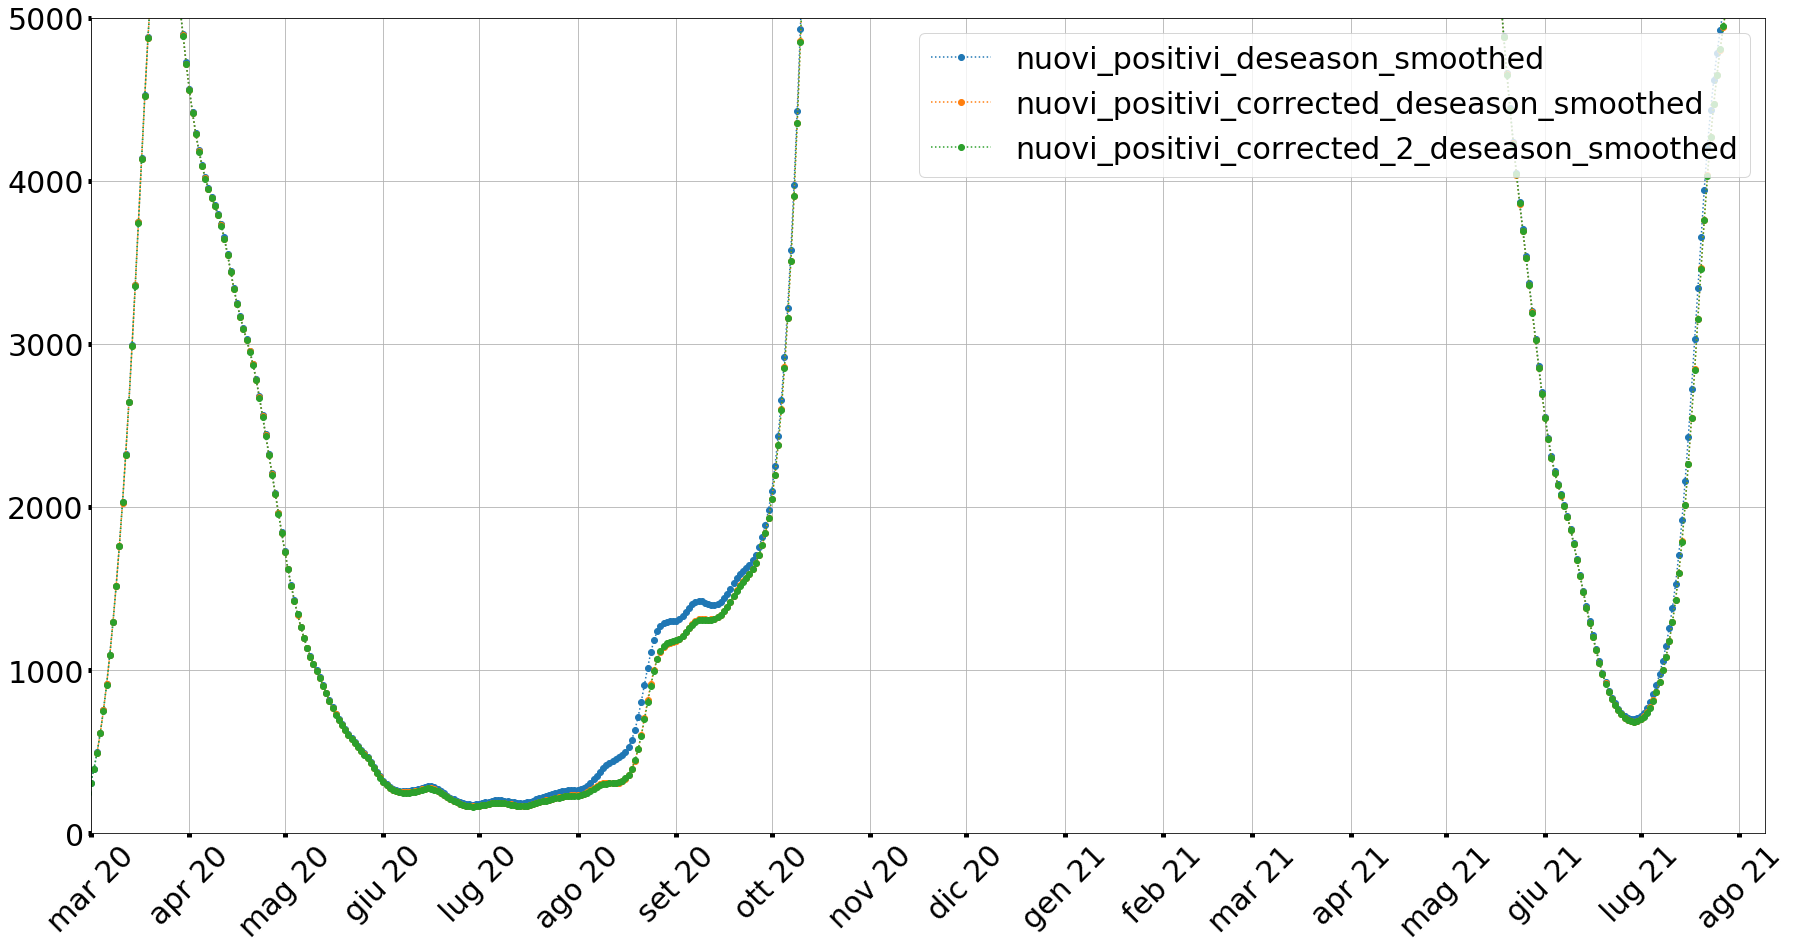

In [35]:
plotting.plot_series(
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields': [
            'nuovi_positivi_deseason_smoothed',
            'nuovi_positivi_corrected_deseason_smoothed',
            'nuovi_positivi_corrected_2_deseason_smoothed'
        ],
    }],
    xlim=(datetime(2020,3,1), DPC_data.data.max()),
    ylim=(0,5000),
    legend_loc="upper right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_global'),
    quality=40
)

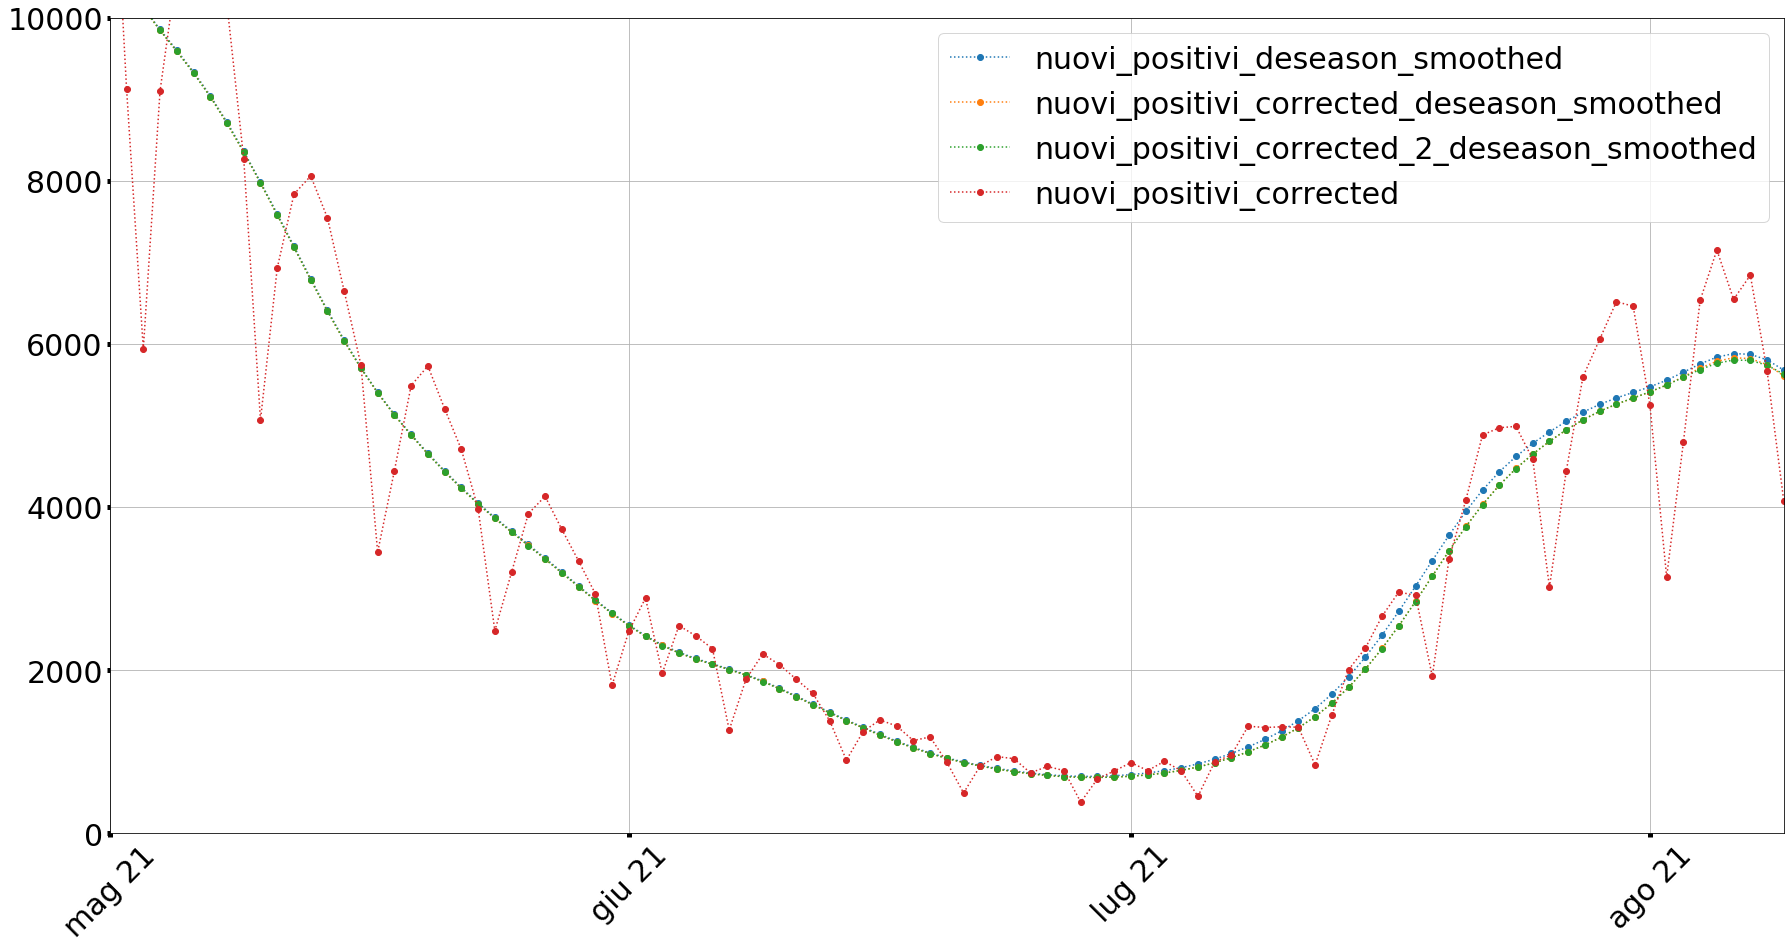

In [37]:
plotting.plot_series(
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields': [
            'nuovi_positivi_deseason_smoothed',
            'nuovi_positivi_corrected_deseason_smoothed',
            'nuovi_positivi_corrected_2_deseason_smoothed',
            'nuovi_positivi_corrected'
        ],
    }],
    xlim=(datetime(2021,5,1), DPC_data.data.max()),
    ylim=(0,10000),
    legend_loc="upper right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_global'),
    quality=40
)

$R_t$:
- corrected
- imported

or:
- total
- corrected

- total: nuovi_positivi with deseason and rel residuals
- corrected: nuovi_positivi_corrected with deseason and rel residuals

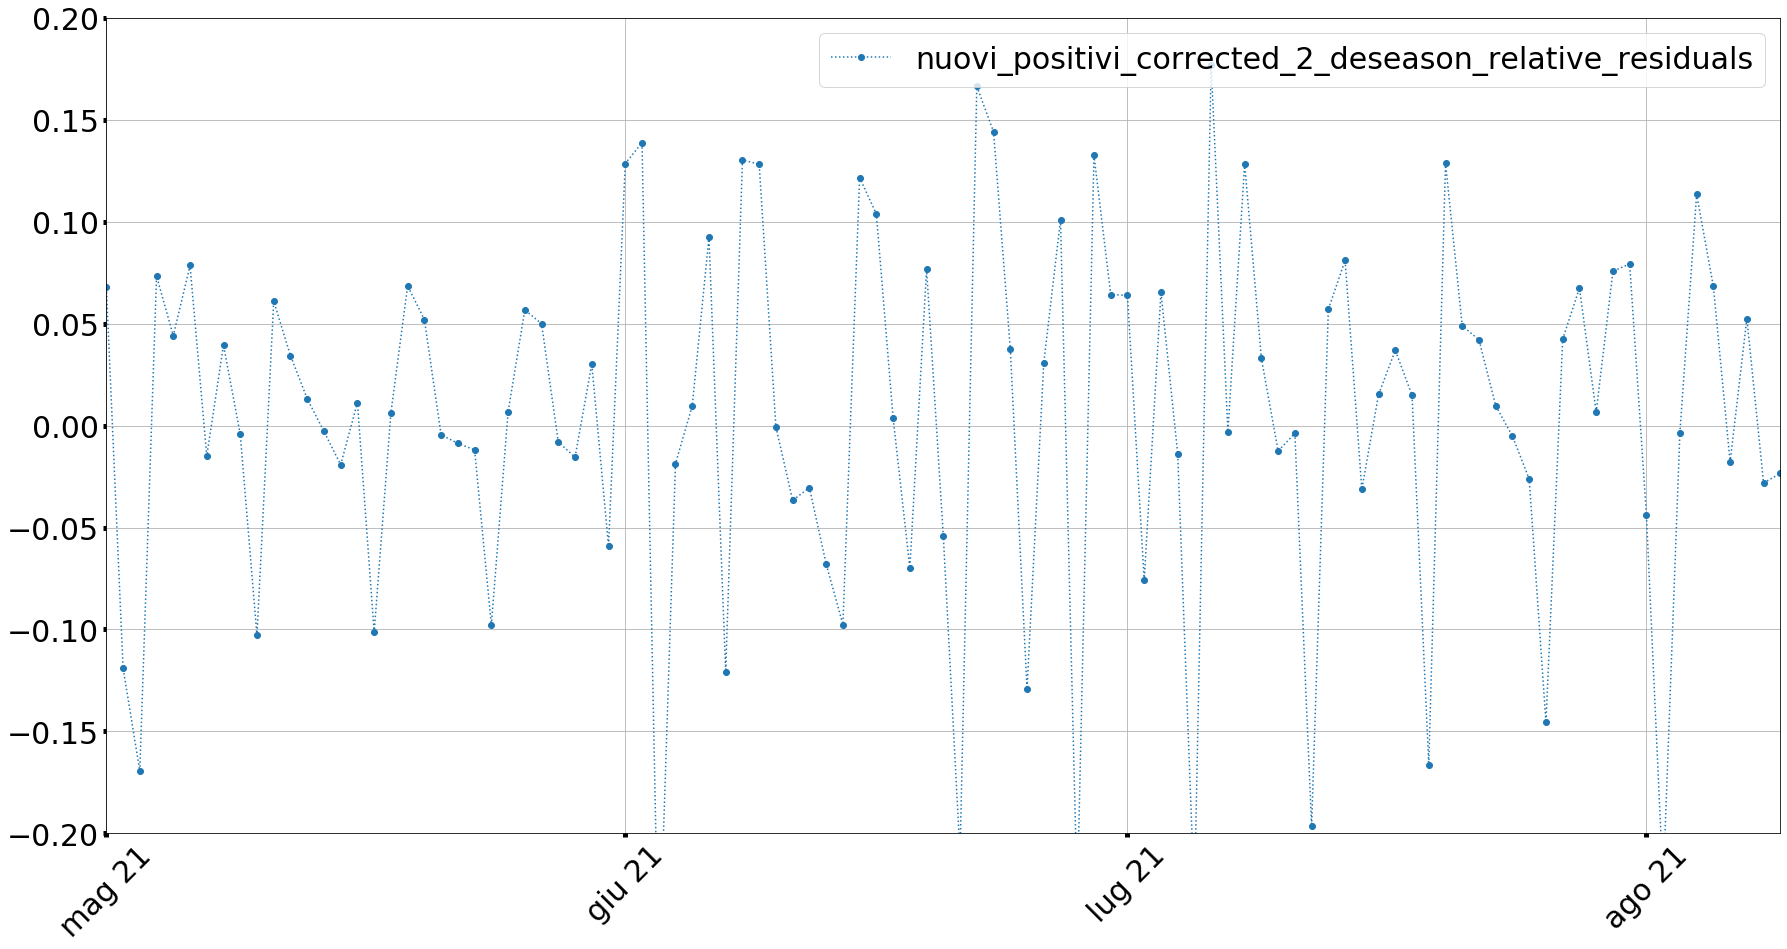

In [38]:
plotting.plot_series(
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields': [
            'nuovi_positivi_corrected_2_deseason_relative_residuals',
        ],
    }],
    xlim=(datetime(2021,5,1), DPC_data.data.max()),
    ylim=(-0.2,0.2),
    legend_loc="upper right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_global'),
    quality=40
)

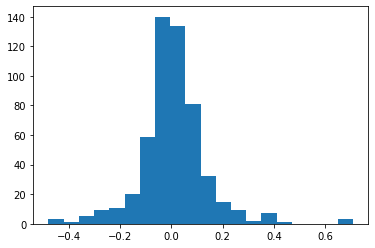

In [39]:
_ = plt.hist(DPC_data.nuovi_positivi_corrected_2_deseason_relative_residuals, bins=20)

In [40]:
DPC_data['nuovi_positivi_corrected_2_deseason_smoothed_Rt'] = naive.compute_Rt(
    DPC_data.nuovi_positivi_corrected_2_deseason_smoothed.fillna(0), alpha=alpha, beta=beta,
    imported_series = DPC_data.nuovi_positivi_deseason_smoothed.fillna(0)-DPC_data.nuovi_positivi_corrected_2_deseason_smoothed.fillna(0)
).fillna(0)

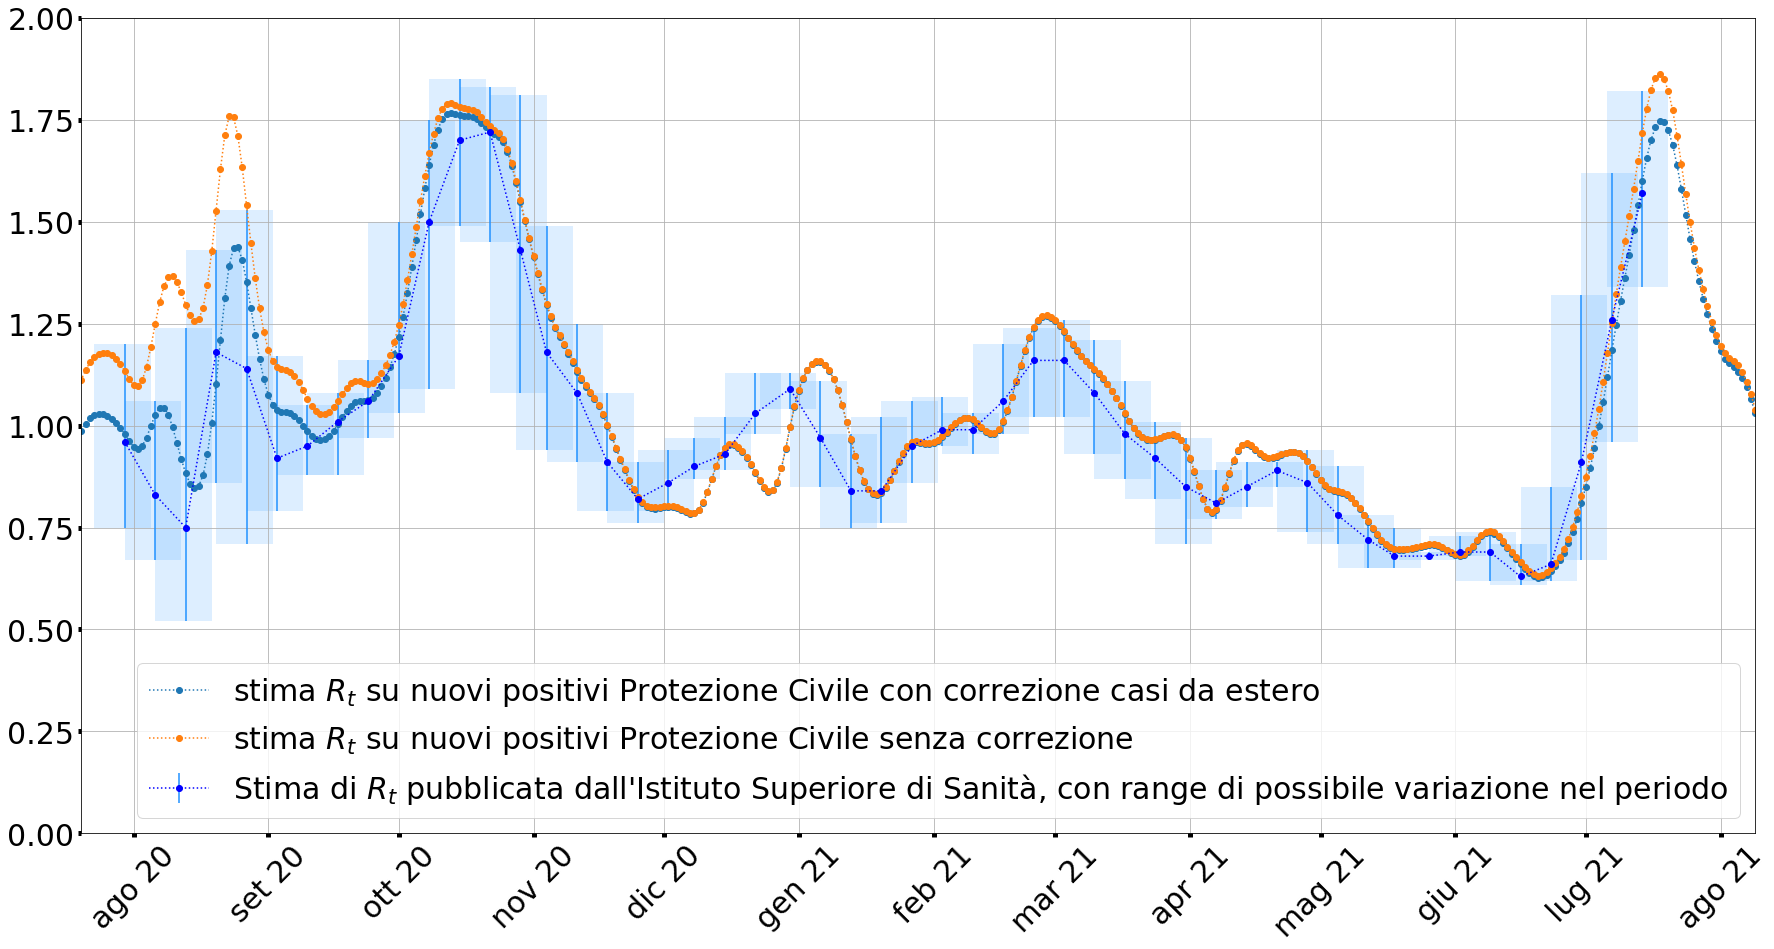

In [41]:
plotting.plot_series(
    data=[
        {
            'df': ISS_Rt_clean,
            'xfield': 'Rt_reference_date',
            'yfields': ['Rt'],
            'bars': [['Rt_95_err_min','Rt_95_err_max']],
            'timeranges': [['computation_time_range_start', 'computation_time_range_end']],
            'labels': ['Stima di $R_t$ pubblicata dall\'Istituto Superiore di Sanità, con range di possibile variazione nel periodo'],
            'colors': ['blue']
        },        
        {
            'df': DPC_data,
            'xfield': 'data',
            'yfields': [
                'nuovi_positivi_corrected_2_deseason_smoothed_Rt', 
                'nuovi_positivi_deseason_smoothed_Rt', 
            ],
            'labels': [
                'stima $R_t$ su nuovi positivi Protezione Civile con correzione casi da estero',
                'stima $R_t$ su nuovi positivi Protezione Civile senza correzione'
            ]
        },
        
    ],
    xlim=(datetime(2020,7,20), DPC_data.data.max()),
    ylim=(0.,2.),
    legend_loc="lower right",
    major_locator=mdates.MonthLocator(bymonthday=1),
    major_formatter=mdates.DateFormatter("%b %y"),
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_global'),
    quality=40
)


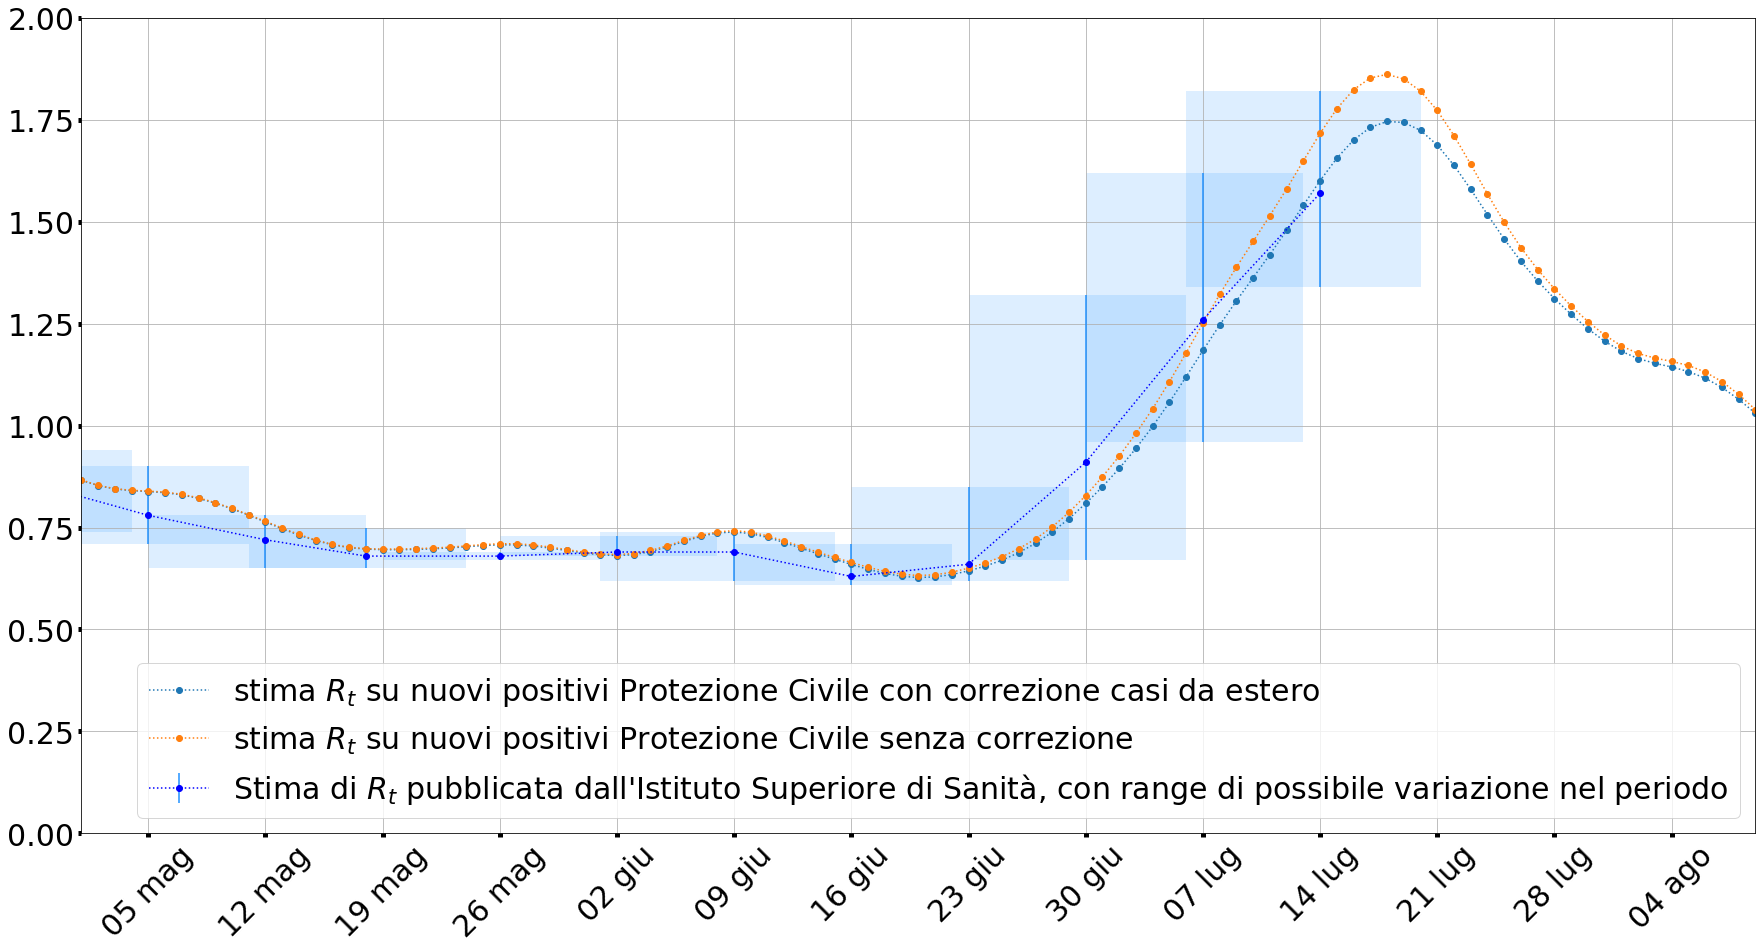

In [42]:
plotting.plot_series(
    data=[
        {
            'df': ISS_Rt_clean,
            'xfield': 'Rt_reference_date',
            'yfields': ['Rt'],
            'bars': [['Rt_95_err_min','Rt_95_err_max']],
            'timeranges': [['computation_time_range_start', 'computation_time_range_end']],
            'labels': ['Stima di $R_t$ pubblicata dall\'Istituto Superiore di Sanità, con range di possibile variazione nel periodo'],
            'colors': ['blue']
        },        
        {
            'df': DPC_data,
            'xfield': 'data',
            'yfields': [
                'nuovi_positivi_corrected_2_deseason_smoothed_Rt', 
                'nuovi_positivi_deseason_smoothed_Rt', 
            ],
            'labels': [
                'stima $R_t$ su nuovi positivi Protezione Civile con correzione casi da estero',
                'stima $R_t$ su nuovi positivi Protezione Civile senza correzione'
            ]
        },
    ],
    xlim=(datetime(2021,5,1), DPC_data.data.max()),
    ylim=(0.,2.),
    legend_loc="lower right",
    #major_locator=mdates.MonthLocator(bymonthday=1),
    #major_formatter=mdates.DateFormatter("%b %y"),
    #img_file_path_without_extension=os.path.join(settings.BASE_IMAGES_PATH,'italy/importati_perc_global'),
    quality=40
)


In [43]:
from covid19_pytoolbox.modeling.Rt.bayesian import MCMC_sample

In [44]:
tot_chain_len=350
startday = len(DPC_data.nuovi_positivi_deseason_smoothed) - tot_chain_len
onset = DPC_data.nuovi_positivi_deseason_smoothed.fillna(0).to_numpy()[startday:]
onset_local=DPC_data.nuovi_positivi_corrected_2_deseason_smoothed.fillna(0).to_numpy()[startday:]
rel_eps=DPC_data.nuovi_positivi_deseason_relative_residuals.to_numpy()[startday:]

In [45]:
#m, t = MCMC_sample(
#    onset=onset,
#    alpha=alpha,
#    beta=beta,
#    rel_eps=rel_eps,
#    eps_window=7,
#    onset_local=onset_local,
#    start=0, window=None, 
#    chains=4, tune=4000, draws=4000, 
#    target_accept=0.95, 
#    max_treedepth=10,
#    dry=False, 
#    cores=4,
#    progressbar=True
#)

In [46]:
DPC_data[['data','imported_ratio','imported_ratio_shifted']].tail(10)

,data,imported_ratio,imported_ratio_shifted
523,2021-07-31,0.010859,0.007492
524,2021-08-01,0.030822,0.012556
525,2021-08-02,0.010965,0.014308
526,2021-08-03,0.000000,0.010094
527,2021-08-04,0.000000,0.009120
528,2021-08-05,NaN,0.010582
529,2021-08-06,NaN,0.007637
530,2021-08-07,NaN,0.008344
531,2021-08-08,NaN,0.010859
532,2021-08-09,NaN,0.030822


In [47]:
DPC_data.imported_ratio

0      0.007987
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
528         NaN
529         NaN
530         NaN
531         NaN
532         NaN
Name: imported_ratio, Length: 533, dtype: float64